# **Deep Learning (Neural Network)**

## ***Objectives for this Notebook***
- Introducing the importance of feature scaling and basic concepts behind Neural Networks used in the context of tabular data.
- Create functions to implement Neural Networks into Moragadivand's dataset.

**Deep Learning or Neural Networks**  is a method within Machine Learning (ML) in which the computer learns to accomplish a task through trial and error by analyzing training samples. Neural networks are loosely inspired by how biological neurons are connected and signal each other. It's important to know that there are many kinds of neural networks that can be used for different kinds of data (images, sounds, etc) and there are specific names for different Neural network architectures (Convolutional Neural Networks, Recurrent Neural Networks, etc.). We will however focus only with basic Neural Network for tabular data (i.e. dataframes).

### **Parts of a Neural Network**

All neural networks despite of their function and kind of data they deal with have in essence these following parts.

![neuralnet.png](https://drive.google.com/uc?export=view&id=1df7Dq1LS9QTFOdLuvOWb1Et6IiMIq4FK)

**1) Input layer:** is the layer that we use to feed our initial data. These can be data tables, text, images, etc. In our case we would be working with a data table, and this layer will contain the same amount of nodes as there are feature columns in our dataset.

**2) Hidden layers:** are the ones that will further process the information they receive from the input layer. In the example above we have 2 hidden layers but the amount of layers can vary depending on the task.

**3) Output layer:** is the final layer where we get our predictions, because we are dealing with classification of just 2 classes we will have 2 nodes in this layer.

**4) Nodes:** are the the components of each layer and it represents a center where computation and mathematical equations determine what information is passed to the next layer. Nodes are connected to the following layers differently.

**5) Weights:** are values that are meant to show the strenght of the relationship between each node. The general idea is that a neural network starts with a random set of weights and then during training, the weights get updated in a trial and error fashion until it finds the best combination of weights that will yield the highest performing model.
**Notice that in the image above, every black arrow has its own weight**


### **1) Importing Packages needed**
For Neural Networks we will introduce some new python packages: **Keras** and **Tensorflow**. Both of these are widely used within the Python community to construct Neural Networks.

In [1]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

# import tensorflow as tf
# from tensorflow.python.compiler.xla import mpu

# Import packages for Neural Networks model
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import scale
from sklearn.utils.class_weight import compute_class_weight
import keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Imports for model evaluation
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model

# Imports for file management
import os
# from google.colab import drive
# drive.mount('/content/drive')

**SEED SETTING**

There is a lot of randomnes that contribute to Neural Networks results. Nevertheless, a good Neural Network Model should not depend on the seed but the data used and the architechture, given this, metrics should not be extremely affected by seed setting. Therefore this randomness is actually desired and not a problem.

However, for the sake of this learning tutorial and for reproducibility of these results we will be fixing **seed_value: 42** for all the background computations. Below we list the different sources of randomnes:

- Within Environment
- Within Python language
- Within specific packages (numpy, tensorflow)
- When choosing splits for training and testing data
- Within Learning Algorythm:
  - Neural network sets random weights at the beggining of training
  - Some special layers such as Dropout layers introduce randomness

The code below will **seed_value: 42** globally for the environment, the **python** language and for 2 packages (**numpy and tensorflow**). We will also quickly indicate where we have set other seeds. Everytime a seed is set you will see `seed_value` within the code of this notebook.



In [2]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

### **2) Loading CSV file and creating dataframes for each antibiotic**

As in all previous ML model Notebooks, We will load our original dataframe, which contains all antibiotic drug labels and all features (GYS) and then we will be creating a dataframe for each antibiotic using different functions.

#### **a) Loading CSV created from previous notebook**

**NOTE:** Code below is the same as in previous notebook

In [3]:
# Loads csv file as a dataframe
filepath = '../../Moradigaravand_dataset/'

# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")
All_Drugs_df.head()

/var/folders/cz/vjt5grr94cn0qr63v4qx4qth0000gn/T/ipykernel_31027/3404063230.py:5: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")


,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


#### **b) Changing "R" to 0 and "S" to 1  for Deep Learning Model**
Neural Networks work using numeric values, therefore we will be converting all our target labels into floats. The last line of code shows the recoded version of all the labels for the antibiotic drugs.

In [4]:
# creating a list of antibiotic names
drug_list = All_Drugs_df.iloc[:,1:13].columns

# converts all S values into 1 for each antibiotic
for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "S", drug] = 1.0

# converts all R values into 0 for each antibiotic
for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "R", drug] = 0.0

# Checking at how S and R classes were recoded
All_Drugs_df.head()

,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,1.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,1.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,1.0,1.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### **3) Separating each Drug Dataframe into 4 sections : Training (features and labels) and Testing (features and labels)**

**NOTE:** Code below is the same as in previous notebook

**a) Creating Testing and Training datasets for each antibiotic drug**

 *Seed value was used in the train_test_split() function, to split the data consistentently, that is, the observations chosen to be part of the training chunk will be consistent regardless of how many times the code is ran.*



In [5]:
# Separating each dataframe into Labels and Features for training and testing data.
# Our function uses the handy train_test_split() function.

def Split_train_test(drug):
  #here we make a list of the columns we want to keep: the column for the isolate, the column for the drug we are interested in and all features (starting from column 13).
  df_list = [All_Drugs_df[["Isolate",drug]], All_Drugs_df.iloc[:,13:]]

  #here we create a data frame with just the columns we wanted to keep.
  Drug_df = pd.concat(df_list, axis=1)

  #here we drop all rows with missing data
  Drug_df = Drug_df.dropna()

  # Creating a dictionary to store each antibiotic datasets
  Train_test_dic = {}

  # Defining the label columns
  labels = Drug_df[drug]

  # Defining features columns
  features = Drug_df.drop(columns=[drug])

  # Separating training (features and labels) and testing (features and labels) datasets
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=seed_value, stratify=labels)

  # storing each data chunk in a dictionary
  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [18]:
AMX_Train_test_dic["features_train"] 

,Isolate,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,Year_2003.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
736,11658_7#82,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
73,11657_5#78,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
972,11679_5#57,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
907,11679_4#85,False,False,False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1265,11679_8#69,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,11657_5#74,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
645,11658_6#83,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
545,11658_5#79,False,False,False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
973,11679_5#58,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Implementing the function Split_train_test() for AMC example
AMX_Train_test_dic = Split_train_test("AMX")

# checking the shape of each dataframe or series stored in the dictionary created for drug AMC
print("AMX")
for k, df in AMX_Train_test_dic.items():
  print(k, df.shape)
  # counting how many of the labels have susceptible versus resistant ones
  if k.startswith("labels"):
    print(df.value_counts())

AMX
labels_train (732,)
AMX
0.0    443
1.0    289
Name: count, dtype: int64
features_train (732, 18292)
labels_test (362,)
AMX
0.0    219
1.0    143
Name: count, dtype: int64
features_test (362, 18292)


Remember that our target values have been recoded. **0.0 is Resistance (R)** and **1.0 is Susceptible (S)**. And in our implementation we used the antibiotic AMX. The total number of training observations is 732.

### **4) Creating different combination of features before training**

Similar to previous notebooks, we have created a function that helps us choose independently what group of features we would like to train with (Gene Absence Presence or Absence (**G**), Year of Isolation (**Y**) and/or Population Structure (**S**). But for Neural Networks, we have added a subtle but important difference between this function and the prior ones created. In here we specifically ask our features to be **Scaled**.

**Scaling:** is a technique where we try to change the numeric values in all columns so that they share the same scale. Scaling is particularly useful for Neural Networks as it helps the model find the minima of the cost function quicker. There are different ways to rescale data, the two main ways are: [Normalization and Standarization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/#Why_Should_We_Use_Feature_Scaling?).


In [7]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['G', 'S', 'GY', 'SY', 'GS', 'GYS']

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, drug, combo):

  # creating Year column filters for features_df
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Population structure column filters for features_df
  pop_str_filter = [col for col in features_df if col.startswith("cutoff")]
  pop_struc_feat = features_df[pop_str_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in pop_str_filter and col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = scale(G_feat_df.drop(columns=['Isolate']))
    return G_feat_df

  if combo == 'S':
    df_list = [features_df['Isolate'], pop_struc_feat]
    S_feat_df = pd.concat(df_list, axis=1)
    S_feat_df = scale(S_feat_df.drop(columns=['Isolate']))
    return S_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = scale(GY_feat_df.drop(columns=['Isolate']))
    return GY_feat_df

  if combo == 'SY':
    df_list = [features_df['Isolate'], pop_struc_feat, year_feat]
    SY_feat_df = pd.concat(df_list, axis=1)
    SY_feat_df = scale(SY_feat_df.drop(columns=['Isolate']))
    return SY_feat_df

  if combo == 'GS':
    df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat]
    GS_feat_df = pd.concat(df_list, axis=1)
    GS_feat_df = scale(GS_feat_df.drop(columns=['Isolate']))
    return GS_feat_df

  if combo == 'GYS':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat, pop_struc_feat]
    GYS_feat_df = pd.concat(df_list, axis=1)
    GYS_feat_df = scale(GYS_feat_df.drop(columns=['Isolate']))
    return GYS_feat_df

In the function we created, we scale the features using **scale()**, which actually performs an **Standarization** (where values are mean centered and distance from mean is measured in standard deviations). Without scaling values, the Neural Network could get biased towards features that have a higher order of magnitude.

Below we can see an example of the difference between raw values and standarized values for two columns. Notice that in raw residuals the standard deviations are not the same. Without scaling its hard to compare which variable of the two might be more important as their ranges differ.



In [8]:
# features before scaling: Raw values
AMX_Train_test_dic['features_train'][['cutoff_25459','cutoff_2']].describe()

,cutoff_25459,cutoff_2
count,732.000000,732.000000
mean,0.047814,968.441257
std,0.522184,628.752643
min,0.000000,3.000000
25%,0.000000,343.250000
50%,0.000000,1121.500000
75%,0.000000,1549.750000
max,8.000000,1932.000000


Below we have the scaled features and we can notice the following:
- All feature descriptives get smaller
- The means and ranges are still different like in our unscaled data
- The standard deviations are the same now.

Now we can compare the values based on the number of standard deviations away from their mean. We are able to tell within the same observation and for both variables whether they represent a typical value (sd closer to mean) or an extreme value (sd further from mean). Now our model has an easier way to tell which of the two features might be more relevant.

It's important to know that feature scaling may not always make a difference, it really depends on the type of Machine Learning algorithm you choose. For example, we did not do it for previous notebooks or tree based methods, but we did it in here. You can read more about it in this summary [article](https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048#:~:text=Feature%20scaling%20is%20the%20process,need%20to%20perform%20feature%20scaling.)

In [9]:
# features after scaling: standarization
feat_scaled = scale(AMX_Train_test_dic['features_train'][['cutoff_25459','cutoff_2']])
feat_scaled = pd.DataFrame(feat_scaled, columns=[['cutoff_25459_(scaled)','cutoff_2_(scaled)']])
feat_scaled.describe()

,cutoff_25459_(scaled),cutoff_2_(scaled)
count,7.320000e+02,7.320000e+02
mean,1.820038e-17,-2.184045e-17
std,1.000684e+00,1.000684e+00
min,-9.162837e-02,-1.536537e+00
25%,-9.162837e-02,-9.950157e-01
50%,-9.162837e-02,2.435988e-01
75%,-9.162837e-02,9.251750e-01
max,1.523911e+01,1.533540e+00


Now we are ready to implement our function in a complete training dataset. Instead of having just 2 columns being scaled, it will do it for all the feature columns in the G and S datasets for the antibiotic "AMX".

In [10]:
# Implementing combo_feat() function created for training data
AMX_GS_train_array = combo_feat(AMX_Train_test_dic['features_train'],"AMX","GS")

# Each list within the array represents a row
AMX_GS_train_array

array([[ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.03698634,
         0.        ,  0.        ]])

In [34]:
X_train = AMX_Train_test_dic["features_train"]

In [95]:
y_train = AMX_Train_test_dic["labels_train"]

In [82]:
y_train

736     1.0
73      0.0
972     0.0
907     0.0
1265    0.0
       ... 
69      1.0
645     1.0
545     1.0
973     0.0
751     1.0
Name: AMX, Length: 732, dtype: object

### **5.0) Creating Ktrain Deep Learning Model**
Neural Networks contain many hyperparameters we can tune, the input layer in this case doesn't need to be set up as it is determined by the amount of features we are using to train. But we will be setting the hidden layers and the final output layer.:
- The number of nodes for the hidden first layer.
- The number of hidden layers we want after the first one.
- The number of nodes for the subsequent layers
- The dropout rate for hidden layers
- The learning rate


In [35]:
AMX_Train_test_dic

{'labels_train': 736     1.0
 73      0.0
 972     0.0
 907     0.0
 1265    0.0
        ... 
 69      1.0
 645     1.0
 545     1.0
 973     0.0
 751     1.0
 Name: AMX, Length: 732, dtype: object,
 'features_train':          Isolate  Year_1970.0  Year_1977.0  Year_1994.0  Year_1997.0  \
 736   11658_7#82        False        False        False        False   
 73    11657_5#78        False        False        False        False   
 972   11679_5#57        False        False        False        False   
 907   11679_4#85        False        False        False        False   
 1265  11679_8#69        False        False        False        False   
 ...          ...          ...          ...          ...          ...   
 69    11657_5#74        False        False        False        False   
 645   11658_6#83        False        False        False        False   
 545   11658_5#79        False        False        False        False   
 973   11679_5#58        False        False        Fa

In [64]:
y_train = y_train["AMX"].astype(int)
y_train

736     1
73      0
972     0
907     0
1265    0
       ..
69      1
645     1
545     1
973     0
751     1
Name: AMX, Length: 732, dtype: int64

In [68]:
y_train.unique()

array([1, 0])

In [75]:
X_train.isna().sum()

0        0
1        0
2        0
3        0
4        0
        ..
18264    0
18265    0
18266    0
18267    0
18268    0
Length: 18269, dtype: int64

In [116]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268
736,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
73,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
972,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
907,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
1265,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
645,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
545,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
973,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0


In [89]:
y_train = pd.DataFrame(y_train)

In [90]:
y_train

,AMX
736,1.0
73,0.0
972,0.0
907,0.0
1265,0.0
...,...
69,1.0
645,1.0
545,1.0
973,0.0


In [94]:
y_train

,AMX
736,1.0
73,0.0
972,0.0
907,0.0
1265,0.0
...,...
69,1.0
645,1.0
545,1.0
973,0.0


In [127]:
Xy_df = pd.concat([X_train, y_train], axis=1)

In [128]:
Xy_df["AMX"] = Xy_df["AMX"].astype(float)

In [134]:
Xy_df["AMX"].astype(int)

736     1
73      0
972     0
907     0
1265    0
       ..
69      1
645     1
545     1
973     0
751     1
Name: AMX, Length: 732, dtype: int64

In [136]:
Xy_df["Label"] = Xy_df["AMX"]

In [138]:
Xy_df["Label"]


736     1
73      0
972     0
907     0
1265    0
       ..
69      1
645     1
545     1
973     0
751     1
Name: Label, Length: 732, dtype: int64

In [139]:
Xy_df

,0,1,2,3,4,5,6,7,8,9,...,18261,18262,18263,18264,18265,18266,18267,18268,AMX,Label
736,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,1.0,1.0
73,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,0.0,0.0
972,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,0.0,0.0
907,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,0.0,0.0
1265,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,1.0,1.0
645,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,1.0,1.0
545,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,1.0,1.0
973,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0,0.0,0.0


In [140]:
# Create a

# Create a train, validation, and preprocessor from the Pandas DataFrame
trn, val, preproc = tabular.tabular_from_df(Xy_df, label_columns=["AMX"], random_state=42)

# Print the train, validation, and preprocessor
print(trn)
print(val)
print(preproc)

TypeError: 'in <string>' requires string as left operand, not int

In [122]:
trn, val, preproc = tabular.tabular_from_df(Xy_df, label_columns=["AMX"], random_state=42)


TypeError: 'in <string>' requires string as left operand, not int

In [36]:
import ktrain
from ktrain import tabular

/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
model = tabular.tabular_classifier('mlp', AMX_GS_train_array)

Exception: 
            Please pass training data in the form of data returned from a ktrain tabular_from* function.
            

In [48]:
y_train = pd.DataFrame(AMX_Train_test_dic['labels_train'])

In [49]:
y_train

,AMX
736,1.0
73,0.0
972,0.0
907,0.0
1265,0.0
...,...
69,1.0
645,1.0
545,1.0
973,0.0


In [50]:
y_train.index

Index([ 736,   73,  972,  907, 1265, 1148, 1190,  242,  229,   72,
       ...
        210,  455, 1238,  996, 1183,   69,  645,  545,  973,  751],
      dtype='int64', length=732)

In [51]:
X_train = pd.DataFrame(AMX_GS_train_array, index=y_train.index)

In [52]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268
736,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
73,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
972,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
907,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
1265,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
645,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
545,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
973,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0


In [59]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268
736,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
73,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
972,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
907,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
1265,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
645,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
545,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0
973,0.0,0.0,0.0,0.036986,0.0,0.036986,0.036986,0.0,0.0,0.0,...,-0.091628,-0.082555,-0.070021,-0.074125,-0.074125,-0.04965,-0.04965,-0.036986,0.0,0.0


In [57]:
trn, val, preproc = tabular.tabular_from_df(X_train, label_columns=y_train["AMX"], random_state=42)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### **5.1) Creating Deep Learning model and training it per feature combination**
Neural Networks contain many hyperparameters we can tune, the input layer in this case doesn't need to be set up as it is determined by the amount of features we are using to train. But we will be setting the hidden layers and the final output layer.:
- The number of nodes for the hidden first layer.
- The number of hidden layers we want after the first one.
- The number of nodes for the subsequent layers
- The dropout rate for hidden layers
- The learning rate


In [33]:
# Number of nodes on first hidden layer
firstlayer = 200

# Number of hidden layers
numblayer = 2

# Number of nodes on each hidden layer
interlayer = 100

# Dropout rate
dropout = 0.8  # default was 0.8

# Learning rate
lr= 0.001 #original 0.001

After setting some of our Neural Network Paramenters, we can create our function. The other parameters and the architecture of the model is based on how Moragadivand's had it set up for the paper (number of layers and nodes, other parameter settings, etc).

The general structure of how each layer is created is shown below in the pseudo code, we will also briefly define some vocabulary used in our specific code:

<font color="grey">`Model.add(Layertype(#_output_weights, activation= 'specific function', input_shape=#_input_weights)`

For Neural Network *Architechture*:
- **Dense:** This is a kind of layer, where each node from a dense layer receives conexions from all the previous nodes, for this reason they are often called **"fully connected"**.

- **Dropout:** This is a special type of layer with the sole function to block a percentage of weights that pass from one layer to the next. A Dropout rate assigns a percentage of randomly selected neurons in a layer to become inactive, meaning their contribution in the forward pass is not taken into account and therefore the weights in the backward pass towards these dropout neurons do not get updated. This is considered to be a **Regularization method**, meaning it is done so that our model doesn't follow the training data too closely and is able to generalize better for unseen data.

- **Activation function:** is a parameter we can pass for some types of layers, it is essentially a function that computes the output for a layer. For example, for Dense layers we have ["Relu"](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), whereas for dropout layers we dont have one, as they don't need to compute an output, they just block outputs from the layer before from going to the next layer, by converting some of these to 0.
***
For Neural Network *Training behavior*:

<font color="grey">`EarlyStopping(patience=# training epochs)`

- **Early Stopping:** is a parameter that essentially stops the training based on the maximum number of epochs accepted before stopping the training if no improvement is seen.

<font color="grey">`Model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr) ,loss= 'binary_crossentropy', metrics=['accuracy'])`

- **Learning rate**: is a value between 0 and 1, that determines basically how fast our model will try to learn. The higher the learning rate, the less number of epochs (training cycles) is required. This is the most important parameter to tune in a Neural Network. Too large and it will converge too quickly and provide a suboptimal result, too small and it will get stuck.

- **Loss function**: there are many loss functions we can use depending on the type of data and task. A loss function is essentially a method used to evaluate how well our algorithm models our training data. Our objective is to minimize it since its essentially our errors. In our case we use:  *binary_crossentropy* (a mathematical function that measures the difference between predicted probabilities and actual labels in classification task with only 2 classes)

- **Metrics**: this is just a measurement we can look at in order to judge the performance of the model while training, and as our loss function is being optimized.
***
*Seed_values were set here for the initial weights prior to training and for every Dropout layer in the Neural Network*

In [34]:
# creating Deep Learning model function
def run_DL(feat_train_df, lab_train, drug, combo, view_training = True):
  print(drug +" Training combo: "+ combo)

  # Reweighting classes due to imbalanced dataset
  class_labels = np.unique(lab_train)
  reweight = compute_class_weight(class_weight='balanced', classes=class_labels, y=lab_train)

  # Constructing Deep Learning model

  # Choose the type of Neural Network you want create
  DL = Sequential()

  # Adding the first hidden layer.
  DL.add(Dense(int(firstlayer),activation='relu', input_shape=(feat_train_df.shape[1],)))

  # Adding the dropout layer for the first layer.
  DL.add(Dropout(dropout, input_shape=(feat_train_df.shape[1],), seed=seed_value))

  # Create more hidden layers
  for i in range(1,int(numblayer)):
      DL.add(Dense(int(interlayer),activation='relu'))

      # For each of the hidden layers also create dropout
      DL.add(Dropout(dropout, seed=seed_value))

  # Create the output layer that consist only on 2 nodes (we have 2 classes)
  DL.add(Dense(2, activation = 'softmax', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value)))

  # Additional parameters for training (Early stopping)
  early_stopping_monitor= EarlyStopping(patience=50)

  # Compiling model created
  DL.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr) ,loss= 'binary_crossentropy', metrics=['accuracy'])

  # Training with the neural network created
  DL_history = DL.fit(feat_train_df, to_categorical(lab_train), validation_split=0.2, callbacks= [early_stopping_monitor],epochs=10, batch_size=128, class_weight=dict(enumerate(reweight)))

  # visualizing each training
  if view_training == True:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training History')
    print(DL_history.history.keys())
    ax1.plot(DL_history.history['accuracy'])
    ax1.plot(DL_history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(ylabel='accuracy', xlabel='epochs')

    ax2.plot(DL_history.history['loss'])
    ax2.plot(DL_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(ylabel='loss', xlabel='epochs')
    ax2.legend(['train', 'validation'], loc='best')
    fig.tight_layout()
    filepath='./Ecoli_ML_Plots/'
    plt.savefig(filepath + 'DL_' + drug + '_' + combo + '_' + 'training_history.jpg',dpi=400, bbox_inches="tight")

  return DL



<font color="grey">`Model.fit(features, to_categorical(labels), validation_split = percent of training data used for validation, callbacks= [early_stopping_monitor],epochs=# of training cycles, batch_size= # observations fed at a time))`

A Neural Network, is trained in 2 general stages:

**1) Feedforward**: First the observations start on the input layer go through all the hidden layers and then it produces an initial prediction in the output layer.

**2) Backpropagation**: An error is calculated between our actual training labels and the output we got from the Feedforward process. It then adjusts the weights from output layer back to input layer in order to minimize the errors.
***
**Epoch:** Is one cycle of training where the entire dataset goes through a Feedforward process and a Backpropagation one. We have set a total of 10 epochs.

**Batch:** Because feeding the entire dataset might be computationally expensive, it is a common practice to feed our neural network data in batches, we have chosen a batch size of 128.

**Validation Data:** Is a chunk of the training data that is reserved to check if our model is generalizing well to all the training data. This is different from the testing data, because it is being used during model training.

Our total number of observations is 732, and our batch size is 128. Therefore, in one epoch we will have 732/128, so about 5 batches per epoch. Below we will implement our function for the antibiotic AMX and using only the features (G and S).

AMX Training combo: GS
Epoch 1/10


2023-10-30 22:50:46.963014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

1/5 [=====>........................] - ETA: 11s - loss: 1.8799 - accuracy: 0.5078

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.7144 - accuracy: 0.5556 

2023-10-30 22:50:51.546507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

5/5 [==============================] - 6s 892ms/step - loss: 2.7144 - accuracy: 0.5556 - val_loss: 1.0957 - val_accuracy: 0.6054
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 3.8781 - accuracy: 0.5761 - val_loss: 1.2048 - val_accuracy: 0.6531
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 4.1372 - accuracy: 0.5983 - val_loss: 1.2231 - val_accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 3.9672 - accuracy: 0.6068 - val_loss: 1.2590 - val_accuracy: 0.6803
Epoch 5/10
5/5 [==============================] - 0s 19ms/step - loss: 3.8207 - accuracy: 0.6034 - val_loss: 1.1860 - val_accuracy: 0.6803
Epoch 6/10
5/5 [==============================] - 0s 19ms/step - loss: 3.7632 - accuracy: 0.6325 - val_loss: 1.1131 - val_accuracy: 0.6939
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 3.7298 - accuracy: 0.6171 - val_loss: 1.1634 - val_accuracy: 0.7007
Epoch 8/10
5/5 [=====================

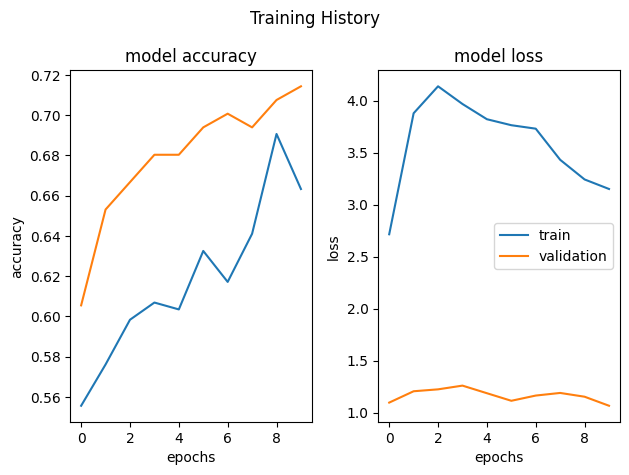

In [35]:
# implementing run_DL() for specific drug feature combination dataframe
DL_AMX_GS_model = run_DL(AMX_GS_train_array, AMX_Train_test_dic['labels_train'],"AMX","GS")

- In the graph above we can see that training and validation data have an upwards direction, meaning that we can see that accuracies for both training and validation are going up, meaning there is learning happening.
- We notice that the **training set** has a lower overall accuracy and a higher loss than the **validation set**, this is not usually the case, we would normally observed the reversed pattern. Because the validation is supposed to simulate unseen data it should have lower accuracies and higher loss, but because **Dropout layer** is implemented, regularization happens and this generalizability makes the validation metrics better. You can test this by lowering the dropout rates in a new session of this notebook, in doing so the lines will beggin to overlap and we will start to see more of a reversed pattern. The current dropout rate is at 0.8.  

In the code below we can graph our Neural Network model architechture:


In [36]:
# plotting the schematics of our model
plot_model(DL_AMX_GS_model, to_file='./EColi_ML_Plots/DL_AMX_GS_model_Architechture.jpg', show_shapes=True, show_layer_activations=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


We can see in the figure that the Input layers input contains 18269 nodes, this is because each node pertains to one feature. Remember that this model was trained with only G and S dataset features. Our input layer nodes will change depending on out training data.

For each layer we can see the following information displayed:
- The name of the layer (example: dense_input)
- The type of neurons the layer contains (example: Dense, Droput)
- The activation function the layer uses (example: softmax, relu)
- The amount of connections for the nodes it receives (input) - The amount of connections leaving the node (output). For dropout layers, we see that input and output shape are the same. However, when a weight gets filtered here, the amount passed is 0. Also, which neurons' weights become 0 changes every cycle of training, which is why everytime we run the code it will give you slightly different results.


### **6) Making predictions from Deep Learning model**

After training our Neural network we are now ready to make predictions.

In [37]:
# creating a function using the model created and trained and the feature combinations from testing data
def predict(DL_combo_Model, features_test):
  labels_pred = DL_combo_Model.predict(features_test)
  labels_pred = np.argmax(labels_pred, axis=1)
  return labels_pred

We will now use our **combo_feat()** function to choose the appropiate data feature combination for Testing. In the example below, we use the combination of features G and S.

In [38]:
# Implementing combo_feat() function created for testing data
AMX_GS_test_array = combo_feat(AMX_Train_test_dic['features_test'],"AMX","GS")

# Each list within the array represents a row
print(AMX_GS_test_array)
print("Number of rows: ",len(AMX_GS_test_array))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of rows:  362


Then we will implement our **predict()** function and checkout our predictions!

Remember that 0 means **Resistant (R)** and 1 means **Susceptible (S)**

In [39]:
# Implementation of the predict() function using the feature combination "GS"
AMX_GS_labels_pred = predict(DL_AMX_GS_model,AMX_GS_test_array)

# observe how many predictions were made for each category "R"=0 and "S"=1
print("Labels predicted: ")
print(AMX_GS_labels_pred)

2023-10-30 22:51:01.521730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 28ms/step
Labels predicted: 
[1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0
 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0
 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0
 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1]


### **7) Evaluating our model using a confusion matrix and metrics**

Similarly to the previous notebook, we will evaluate our Deep learning model by using a Confusion Matrix and respective metrics. Below is a quick review of these, remember that there is one Accuracy score, but Recall and Presicion should have as many sets as classes our model its trained to predict:

|<font size=3>Metrics|<font size=3>General formula| <font size=3>Formula for 2 classes|
|--|:-:|:-:
|<font size=3>**Accuracy**|<font size=3>$\frac{Correctly \ classified}{All \ Predicted}$|<font size=3>$\frac{TP + TN}{TP + TN + FN + FP}$|
|<font size=3>**R Recall:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Actual \ R}$|<font size=3>$\frac{TP}{TP + FN}$|
|<font size=3>**R Precision:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Predicted \ R}$|<font size=3>$\frac{TP}{TP + FP}$|

In [40]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(DL_combo_model, features_test, labels_test, labels_pred, cf= True, show_results= True):

  labels_test = np.asfarray(labels_test,float)
  score = DL_combo_model.evaluate(features_test, to_categorical(labels_test)) # only take accuracy

  labels = unique_labels(labels_test, labels_pred)
  inp = precision_recall_fscore_support(labels_test, labels_pred, labels=labels, average=None)
  report = np.asarray(inp).ravel().tolist()
  report= pd.DataFrame(report, index = ['PRC_R','PRC_S','RCL_R','RCL_S','FSc_R','FSc_S','Sc_R','Sc_S'])
  report = report.transpose()

  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=labels, sample_weight=None)
    labels= np.where(labels<1,"R","S")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',score[1])
    print('R recall:',report['RCL_R'][0])
    print('S recall:',report['RCL_S'][0])
    print('R precision:',report['PRC_R'][0])
    print('S precision:',report['PRC_S'][0])
  return [score[1], report['RCL_R'][0], report['RCL_S'][0], report['PRC_R'][0], report['PRC_S'][0]]

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


 8/12 [===================>..........] - ETA: 0s - loss: 0.9973 - accuracy: 0.7461

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 1s 69ms/step - loss: 0.9642 - accuracy: 0.7348


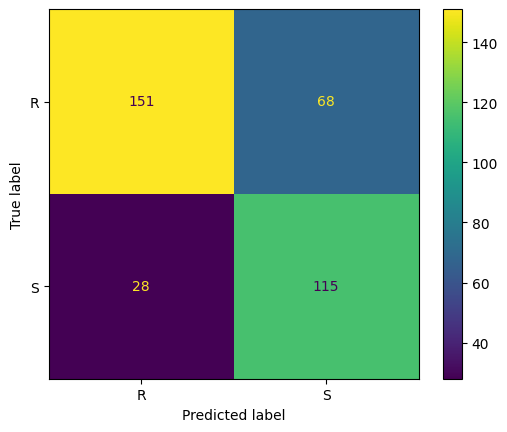

Results
Accuracy: 0.7348066568374634
R recall: 0.6894977168949772
S recall: 0.8041958041958042
R precision: 0.8435754189944135
S precision: 0.6284153005464481


In [41]:
# implementing the evaluate() function
Model_Report_adjusted_3 = evaluate(DL_AMX_GS_model,AMX_GS_test_array, AMX_Train_test_dic['labels_test'],AMX_GS_labels_pred)

### **8) Use all functions and evaluate every drug in every feature combination!**
**NOTE:** Code below is the same as in previous notebook

#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [42]:
# let's check all drugs
print(drug_list)

# let's see all combinations we are interested in
print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['G', 'S', 'GY', 'SY', 'GS', 'GYS']


#### **b) Create a loop that will go through all our functions using the lists above**

In [43]:
# Lets use all our functions this time and save our report into a single data structure
DL_model_metrics = {}

for drug in drug_list:
  print(drug)
  Test_Train_dic = Split_train_test(drug) # splits each drug df into a dictionary with testing and training data
  for combo in combo_list:
    # Training each drug_combo features
    labels_train = Test_Train_dic["labels_train"]
    features_train = combo_feat(Test_Train_dic["features_train"], drug, combo) # create corresponding feature_df for training
    DL_combo_model = run_DL(features_train, labels_train, drug, combo, view_training = False) # runs deep learning model using the corresponding training feature_df

    # Predicting each drug_combo features
    features_test = combo_feat(Test_Train_dic["features_test"], drug, combo) # create corresponding feature_df for testing
    labels_pred = predict(DL_combo_model, features_test) # generate predictions based on the feature combination tested

    # Evaluating our models72*
    labels_test = Test_Train_dic["labels_test"]
    report = evaluate(DL_combo_model,features_test, labels_test, labels_pred, cf=False, show_results= False)
    DL_model_metrics[drug+"_"+combo] = report

    print(report)

CTZ


CTZ Training combo: G
Epoch 1/10


2023-10-30 22:51:42.561121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 2.6851 - accuracy: 0.5361

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.6882 - accuracy: 0.5386

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 22:51:48.528953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 674ms/step - loss: 2.6882 - accuracy: 0.5386 - val_loss: 0.3862 - val_accuracy: 0.8385
Epoch 2/10
9/9 [==============================] - 0s 22ms/step - loss: 4.0654 - accuracy: 0.6670 - val_loss: 0.4859 - val_accuracy: 0.8192
Epoch 3/10
9/9 [==============================] - 0s 16ms/step - loss: 3.9288 - accuracy: 0.6979 - val_loss: 0.6828 - val_accuracy: 0.7808
Epoch 4/10
9/9 [==============================] - 0s 16ms/step - loss: 4.5283 - accuracy: 0.6911 - val_loss: 0.7521 - val_accuracy: 0.7962
Epoch 5/10
9/9 [==============================] - 0s 16ms/step - loss: 3.5741 - accuracy: 0.7220 - val_loss: 0.8406 - val_accuracy: 0.8000
Epoch 6/10
9/9 [==============================] - 0s 15ms/step - loss: 3.4876 - accuracy: 0.7133 - val_loss: 0.9471 - val_accuracy: 0.7577
Epoch 7/10
9/9 [==============================] - 0s 15ms/step - loss: 3.5366 - accuracy: 0.6931 - val_loss: 0.8981 - val_accuracy: 0.7692
Epoch 8/10
9/9 [=====================

2023-10-30 22:51:52.458348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 22ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


14/20 [====================>.........] - ETA: 0s - loss: 0.7431 - accuracy: 0.7723

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 45ms/step - loss: 0.7040 - accuracy: 0.7887
[0.7887324094772339, 0.7045454545454546, 0.8021778584392014, 0.36257309941520466, 0.9444444444444444]


CTZ Training combo: S
Epoch 1/10


2023-10-30 22:51:55.505047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 1.9913 - accuracy: 0.5332

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.9972 - accuracy: 0.5328

2023-10-30 22:52:00.342387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 7s 487ms/step - loss: 1.9972 - accuracy: 0.5328 - val_loss: 0.4409 - val_accuracy: 0.8000
Epoch 2/10
9/9 [==============================] - 0s 15ms/step - loss: 1.8496 - accuracy: 0.6380 - val_loss: 0.4139 - val_accuracy: 0.8269
Epoch 3/10
9/9 [==============================] - 0s 13ms/step - loss: 1.7163 - accuracy: 0.6486 - val_loss: 0.4602 - val_accuracy: 0.7885
Epoch 4/10
9/9 [==============================] - 0s 13ms/step - loss: 1.5480 - accuracy: 0.6438 - val_loss: 0.4348 - val_accuracy: 0.8000
Epoch 5/10
9/9 [==============================] - 0s 11ms/step - loss: 1.5233 - accuracy: 0.6216 - val_loss: 0.4202 - val_accuracy: 0.8038
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 1.4297 - accuracy: 0.6583 - val_loss: 0.4011 - val_accuracy: 0.8231
Epoch 7/10
9/9 [==============================] - 0s 13ms/step - loss: 1.3398 - accuracy: 0.6554 - val_loss: 0.3966 - val_accuracy: 0.8038
Epoch 8/10
9/9 [=====================

2023-10-30 22:52:03.392807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 15ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


19/20 [===========================>..] - ETA: 0s - loss: 0.4396 - accuracy: 0.7730

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 1s 41ms/step - loss: 0.4354 - accuracy: 0.7746
[0.7746478915214539, 0.5454545454545454, 0.8112522686025408, 0.3157894736842105, 0.917864476386037]


CTZ Training combo: GY
Epoch 1/10


2023-10-30 22:52:06.978111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.5743 - accuracy: 0.5089

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.6122 - accuracy: 0.5232

2023-10-30 22:52:11.931054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 7s 487ms/step - loss: 2.6122 - accuracy: 0.5232 - val_loss: 0.8279 - val_accuracy: 0.7538
Epoch 2/10
9/9 [==============================] - 0s 20ms/step - loss: 4.1539 - accuracy: 0.6313 - val_loss: 0.5129 - val_accuracy: 0.8308
Epoch 3/10
9/9 [==============================] - 0s 16ms/step - loss: 3.7775 - accuracy: 0.6757 - val_loss: 0.7098 - val_accuracy: 0.7885
Epoch 4/10
9/9 [==============================] - 0s 16ms/step - loss: 3.6021 - accuracy: 0.6940 - val_loss: 0.8277 - val_accuracy: 0.7962
Epoch 5/10
9/9 [==============================] - 0s 17ms/step - loss: 4.0196 - accuracy: 0.6680 - val_loss: 0.9401 - val_accuracy: 0.7577
Epoch 6/10
9/9 [==============================] - 0s 15ms/step - loss: 4.2138 - accuracy: 0.7085 - val_loss: 1.0309 - val_accuracy: 0.7769
Epoch 7/10
9/9 [==============================] - 0s 17ms/step - loss: 4.1353 - accuracy: 0.7355 - val_loss: 1.0899 - val_accuracy: 0.7769
Epoch 8/10
9/9 [=====================

2023-10-30 22:52:15.600403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


10/20 [==============>...............] - ETA: 0s - loss: 0.8927 - accuracy: 0.8031

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 45ms/step - loss: 0.8174 - accuracy: 0.8106
[0.8106416463851929, 0.6818181818181818, 0.8312159709618875, 0.39215686274509803, 0.9423868312757202]


CTZ Training combo: SY
Epoch 1/10


2023-10-30 22:52:18.576000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/9 [===================>..........] - ETA: 0s - loss: 1.9947 - accuracy: 0.5182

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.0279 - accuracy: 0.5357

2023-10-30 22:52:23.631339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 7s 504ms/step - loss: 2.0279 - accuracy: 0.5357 - val_loss: 0.4423 - val_accuracy: 0.7962
Epoch 2/10
9/9 [==============================] - 0s 17ms/step - loss: 1.8142 - accuracy: 0.5878 - val_loss: 0.4461 - val_accuracy: 0.7692
Epoch 3/10
9/9 [==============================] - 0s 14ms/step - loss: 1.4713 - accuracy: 0.6486 - val_loss: 0.4330 - val_accuracy: 0.8115
Epoch 4/10
9/9 [==============================] - 0s 13ms/step - loss: 1.3812 - accuracy: 0.6853 - val_loss: 0.4056 - val_accuracy: 0.8154
Epoch 5/10
9/9 [==============================] - 0s 12ms/step - loss: 1.3746 - accuracy: 0.6757 - val_loss: 0.3951 - val_accuracy: 0.8346
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 1.4472 - accuracy: 0.6824 - val_loss: 0.3830 - val_accuracy: 0.8269
Epoch 7/10
9/9 [==============================] - 0s 12ms/step - loss: 1.2543 - accuracy: 0.6371 - val_loss: 0.3960 - val_accuracy: 0.7962
Epoch 8/10
9/9 [=====================

2023-10-30 22:52:26.680275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 16ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


18/20 [==========================>...] - ETA: 0s - loss: 0.4046 - accuracy: 0.7639

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 43ms/step - loss: 0.3950 - accuracy: 0.7684
[0.7683880925178528, 0.625, 0.7912885662431942, 0.3235294117647059, 0.929637526652452]


CTZ Training combo: GS
Epoch 1/10


2023-10-30 22:52:30.050463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.7453 - accuracy: 0.5346

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.9816 - accuracy: 0.5367

2023-10-30 22:52:35.283496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 7s 520ms/step - loss: 2.9816 - accuracy: 0.5367 - val_loss: 0.7648 - val_accuracy: 0.7385
Epoch 2/10
9/9 [==============================] - 0s 21ms/step - loss: 4.0987 - accuracy: 0.6641 - val_loss: 0.6103 - val_accuracy: 0.8038
Epoch 3/10
9/9 [==============================] - 0s 19ms/step - loss: 5.5596 - accuracy: 0.6998 - val_loss: 0.7188 - val_accuracy: 0.7885
Epoch 4/10
9/9 [==============================] - 0s 16ms/step - loss: 4.8986 - accuracy: 0.7085 - val_loss: 0.7474 - val_accuracy: 0.7962
Epoch 5/10
9/9 [==============================] - 0s 14ms/step - loss: 4.0084 - accuracy: 0.7288 - val_loss: 0.7559 - val_accuracy: 0.7923
Epoch 6/10
9/9 [==============================] - 0s 16ms/step - loss: 4.0193 - accuracy: 0.7278 - val_loss: 0.7374 - val_accuracy: 0.8000
Epoch 7/10
9/9 [==============================] - 0s 15ms/step - loss: 4.1202 - accuracy: 0.7124 - val_loss: 0.7604 - val_accuracy: 0.7885
Epoch 8/10
9/9 [=====================

2023-10-30 22:52:38.956341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


14/20 [====================>.........] - ETA: 0s - loss: 0.8818 - accuracy: 0.7411

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 46ms/step - loss: 0.7750 - accuracy: 0.7574
[0.7574334740638733, 0.75, 0.7586206896551724, 0.3316582914572864, 0.95]


CTZ Training combo: GYS
Epoch 1/10


2023-10-30 22:52:42.899472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 3.0125 - accuracy: 0.4967

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.3509 - accuracy: 0.5125

2023-10-30 22:52:48.707491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 591ms/step - loss: 3.3509 - accuracy: 0.5125 - val_loss: 0.6371 - val_accuracy: 0.8077
Epoch 2/10
9/9 [==============================] - 0s 24ms/step - loss: 4.2447 - accuracy: 0.6805 - val_loss: 0.5588 - val_accuracy: 0.8269
Epoch 3/10
9/9 [==============================] - 0s 21ms/step - loss: 4.6278 - accuracy: 0.6747 - val_loss: 0.7161 - val_accuracy: 0.8077
Epoch 4/10
9/9 [==============================] - 0s 20ms/step - loss: 3.6064 - accuracy: 0.7268 - val_loss: 0.7956 - val_accuracy: 0.8000
Epoch 5/10
9/9 [==============================] - 0s 17ms/step - loss: 4.7507 - accuracy: 0.7017 - val_loss: 0.8933 - val_accuracy: 0.7885
Epoch 6/10
9/9 [==============================] - 0s 17ms/step - loss: 4.8156 - accuracy: 0.7172 - val_loss: 0.9136 - val_accuracy: 0.7923
Epoch 7/10
9/9 [==============================] - 0s 16ms/step - loss: 3.0511 - accuracy: 0.7191 - val_loss: 0.9114 - val_accuracy: 0.8154
Epoch 8/10
9/9 [=====================

2023-10-30 22:52:52.915817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


16/20 [=======================>......] - ETA: 0s - loss: 0.8994 - accuracy: 0.7871

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 48ms/step - loss: 0.7812 - accuracy: 0.8059
[0.8059467673301697, 0.75, 0.8148820326678766, 0.39285714285714285, 0.9532908704883227]
CTX


CTX Training combo: G
Epoch 1/10


2023-10-30 22:52:57.014028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 3.0592 - accuracy: 0.4648

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 3.0601 - accuracy: 0.4849

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
2023-10-30 22:53:02.538006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'

8/8 [==============================] - 8s 659ms/step - loss: 3.0601 - accuracy: 0.4849 - val_loss: 0.8610 - val_accuracy: 0.7309
Epoch 2/10
8/8 [==============================] - 0s 29ms/step - loss: 3.5389 - accuracy: 0.6365 - val_loss: 0.5027 - val_accuracy: 0.8434
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 3.5983 - accuracy: 0.6697 - val_loss: 0.5264 - val_accuracy: 0.8394
Epoch 4/10
8/8 [==============================] - 0s 18ms/step - loss: 3.5458 - accuracy: 0.6837 - val_loss: 0.5159 - val_accuracy: 0.8394
Epoch 5/10
8/8 [==============================] - 0s 20ms/step - loss: 3.0116 - accuracy: 0.7349 - val_loss: 0.4820 - val_accuracy: 0.8514
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 3.1187 - accuracy: 0.7530 - val_loss: 0.4971 - val_accuracy: 0.8394
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 2.9714 - accuracy: 0.7510 - val_loss: 0.5188 - val_accuracy: 0.8193
Epoch 8/10
8/8 [=====================

2023-10-30 22:53:06.544367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 30ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.4799 - accuracy: 0.8566

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 52ms/step - loss: 0.4711 - accuracy: 0.8583
[0.8583061695098877, 0.7698412698412699, 0.8811475409836066, 0.6258064516129033, 0.9368191721132898]


CTX Training combo: S
Epoch 1/10


2023-10-30 22:53:11.332384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 2.0220 - accuracy: 0.5221

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 1.9592 - accuracy: 0.5291

2023-10-30 22:53:16.539328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 9s 593ms/step - loss: 1.9592 - accuracy: 0.5291 - val_loss: 0.4309 - val_accuracy: 0.8193
Epoch 2/10
8/8 [==============================] - 0s 19ms/step - loss: 1.5828 - accuracy: 0.6044 - val_loss: 0.3991 - val_accuracy: 0.8434
Epoch 3/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3456 - accuracy: 0.6536 - val_loss: 0.4138 - val_accuracy: 0.8153
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 1.2426 - accuracy: 0.6496 - val_loss: 0.4118 - val_accuracy: 0.8072
Epoch 5/10
8/8 [==============================] - 0s 14ms/step - loss: 1.0768 - accuracy: 0.6807 - val_loss: 0.3928 - val_accuracy: 0.8112
Epoch 6/10
8/8 [==============================] - 0s 15ms/step - loss: 0.9838 - accuracy: 0.7189 - val_loss: 0.4051 - val_accuracy: 0.8032
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 1.0398 - accuracy: 0.6958 - val_loss: 0.4091 - val_accuracy: 0.8032
Epoch 8/10
8/8 [=====================

2023-10-30 22:53:19.590408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 16ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/20 [=====================>........] - ETA: 0s - loss: 0.4164 - accuracy: 0.8000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 46ms/step - loss: 0.4259 - accuracy: 0.7915
[0.791530966758728, 0.7301587301587301, 0.8073770491803278, 0.4946236559139785, 0.9205607476635514]


CTX Training combo: GY
Epoch 1/10


2023-10-30 22:53:23.088661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 2.5161 - accuracy: 0.5031

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 2.8246 - accuracy: 0.5141

2023-10-30 22:53:28.283021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 7s 606ms/step - loss: 2.8246 - accuracy: 0.5141 - val_loss: 1.2163 - val_accuracy: 0.6908
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 3.8721 - accuracy: 0.6255 - val_loss: 0.6597 - val_accuracy: 0.7992
Epoch 3/10
8/8 [==============================] - 0s 19ms/step - loss: 3.8350 - accuracy: 0.6657 - val_loss: 0.4868 - val_accuracy: 0.8394
Epoch 4/10
8/8 [==============================] - 0s 17ms/step - loss: 4.2135 - accuracy: 0.6958 - val_loss: 0.4573 - val_accuracy: 0.8313
Epoch 5/10
8/8 [==============================] - 0s 19ms/step - loss: 3.4526 - accuracy: 0.7129 - val_loss: 0.4847 - val_accuracy: 0.8193
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 3.0846 - accuracy: 0.7319 - val_loss: 0.5296 - val_accuracy: 0.8032
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 2.6918 - accuracy: 0.7229 - val_loss: 0.4953 - val_accuracy: 0.8233
Epoch 8/10
8/8 [=====================

2023-10-30 22:53:32.043670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


12/20 [=================>............] - ETA: 0s - loss: 0.5323 - accuracy: 0.8255

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 48ms/step - loss: 0.4953 - accuracy: 0.8404
[0.8403908610343933, 0.7857142857142857, 0.8545081967213115, 0.5823529411764706, 0.9391891891891891]


CTX Training combo: SY
Epoch 1/10


2023-10-30 22:53:35.015204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/8 [=========================>....] - ETA: 0s - loss: 2.2127 - accuracy: 0.4754

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 2.1781 - accuracy: 0.4900

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
2023-10-30 22:53:40.115577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'

8/8 [==============================] - 7s 590ms/step - loss: 2.1781 - accuracy: 0.4900 - val_loss: 0.5108 - val_accuracy: 0.7309
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 1.5714 - accuracy: 0.5653 - val_loss: 0.4316 - val_accuracy: 0.7751
Epoch 3/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3497 - accuracy: 0.6406 - val_loss: 0.4360 - val_accuracy: 0.7831
Epoch 4/10
8/8 [==============================] - 0s 14ms/step - loss: 1.3062 - accuracy: 0.6235 - val_loss: 0.4264 - val_accuracy: 0.7631
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 1.0969 - accuracy: 0.6606 - val_loss: 0.4079 - val_accuracy: 0.7871
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 1.0522 - accuracy: 0.6717 - val_loss: 0.4190 - val_accuracy: 0.7871
Epoch 7/10
8/8 [==============================] - 0s 14ms/step - loss: 1.0179 - accuracy: 0.6867 - val_loss: 0.4423 - val_accuracy: 0.7671
Epoch 8/10
8/8 [=====================

2023-10-30 22:53:43.237365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


11/20 [===============>..............] - ETA: 0s - loss: 0.4264 - accuracy: 0.8040

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 44ms/step - loss: 0.4307 - accuracy: 0.7948
[0.7947883009910583, 0.6428571428571429, 0.8340163934426229, 0.5, 0.9004424778761062]


CTX Training combo: GS
Epoch 1/10


2023-10-30 22:53:46.670604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 2.5816 - accuracy: 0.5641

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 3.1085 - accuracy: 0.5653

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
2023-10-30 22:53:51.895544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'

8/8 [==============================] - 7s 599ms/step - loss: 3.1085 - accuracy: 0.5653 - val_loss: 0.9076 - val_accuracy: 0.7470
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 4.0519 - accuracy: 0.6466 - val_loss: 0.6489 - val_accuracy: 0.8233
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 3.9795 - accuracy: 0.6837 - val_loss: 0.5914 - val_accuracy: 0.8434
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 3.9600 - accuracy: 0.7239 - val_loss: 0.4811 - val_accuracy: 0.8635
Epoch 5/10
8/8 [==============================] - 0s 20ms/step - loss: 3.4408 - accuracy: 0.7359 - val_loss: 0.4249 - val_accuracy: 0.8755
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 2.9591 - accuracy: 0.7450 - val_loss: 0.4790 - val_accuracy: 0.8635
Epoch 7/10
8/8 [==============================] - 0s 18ms/step - loss: 2.8833 - accuracy: 0.7590 - val_loss: 0.4756 - val_accuracy: 0.8635
Epoch 8/10
8/8 [=====================

2023-10-30 22:53:55.737623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


16/20 [=======================>......] - ETA: 0s - loss: 0.4172 - accuracy: 0.8535

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 47ms/step - loss: 0.4222 - accuracy: 0.8632
[0.8631922006607056, 0.8095238095238095, 0.8770491803278688, 0.6296296296296297, 0.9469026548672567]


CTX Training combo: GYS
Epoch 1/10


2023-10-30 22:53:59.549308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 3.0152 - accuracy: 0.5508

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x100x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerform

8/8 [==============================] - ETA: 0s - loss: 3.1833 - accuracy: 0.5562

2023-10-30 22:54:04.833648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 7s 611ms/step - loss: 3.1833 - accuracy: 0.5562 - val_loss: 0.9731 - val_accuracy: 0.7189
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 4.0654 - accuracy: 0.6697 - val_loss: 0.6787 - val_accuracy: 0.8313
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 4.1052 - accuracy: 0.6867 - val_loss: 0.5196 - val_accuracy: 0.8474
Epoch 4/10
8/8 [==============================] - 0s 22ms/step - loss: 3.8604 - accuracy: 0.7259 - val_loss: 0.4464 - val_accuracy: 0.8554
Epoch 5/10
8/8 [==============================] - 0s 19ms/step - loss: 3.1892 - accuracy: 0.7329 - val_loss: 0.4520 - val_accuracy: 0.8755
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 3.4059 - accuracy: 0.7430 - val_loss: 0.4620 - val_accuracy: 0.8795
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 2.8459 - accuracy: 0.7520 - val_loss: 0.4868 - val_accuracy: 0.8715
Epoch 8/10
8/8 [=====================

2023-10-30 22:54:08.841602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.4933 - accuracy: 0.8511

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x6x1x2xi1>'


20/20 [==============================] - 2s 47ms/step - loss: 0.5010 - accuracy: 0.8534
[0.8534201979637146, 0.7698412698412699, 0.875, 0.6139240506329114, 0.9364035087719298]
AMP


AMP Training combo: G
Epoch 1/10


2023-10-30 22:54:12.317372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.8162 - accuracy: 0.5182

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.7261 - accuracy: 0.5333

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 22:54:17.778216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.7261 - accuracy: 0.5333 - val_loss: 0.6445 - val_accuracy: 0.7434
Epoch 2/10
4/4 [==============================] - 0s 40ms/step - loss: 3.4045 - accuracy: 0.6133 - val_loss: 0.7859 - val_accuracy: 0.7257
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 4.0233 - accuracy: 0.6178 - val_loss: 0.9014 - val_accuracy: 0.7434
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 4.5034 - accuracy: 0.6067 - val_loss: 1.0168 - val_accuracy: 0.7168
Epoch 5/10
4/4 [==============================] - 0s 25ms/step - loss: 4.0287 - accuracy: 0.6444 - val_loss: 1.0692 - val_accuracy: 0.7080
Epoch 6/10
4/4 [==============================] - 0s 28ms/step - loss: 3.3624 - accuracy: 0.6689 - val_loss: 1.0909 - val_accuracy: 0.7168
Epoch 7/10
4/4 [==============================] - 0s 25ms/step - loss: 3.0530 - accuracy: 0.7178 - val_loss: 1.0946 - val_accuracy: 0.7080
Epoch 8/10
4/4 [========================

2023-10-30 22:54:20.294698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 49ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


7/9 [======================>.......] - ETA: 0s - loss: 0.8523 - accuracy: 0.7054

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 105ms/step - loss: 0.8344 - accuracy: 0.7158
[0.7158273458480835, 0.7259615384615384, 0.6857142857142857, 0.8728323699421965, 0.45714285714285713]
AMP Training combo: S


Epoch 1/10


2023-10-30 22:54:23.078650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 2.2025 - accuracy: 0.5078

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.1801 - accuracy: 0.5244

2023-10-30 22:54:28.028120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 6s 1s/step - loss: 2.1801 - accuracy: 0.5244 - val_loss: 0.6337 - val_accuracy: 0.7080
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 1.8147 - accuracy: 0.5933 - val_loss: 0.6185 - val_accuracy: 0.7345
Epoch 3/10
4/4 [==============================] - 0s 28ms/step - loss: 1.8977 - accuracy: 0.5644 - val_loss: 0.6054 - val_accuracy: 0.6991
Epoch 4/10
4/4 [==============================] - 0s 30ms/step - loss: 1.6541 - accuracy: 0.5844 - val_loss: 0.5967 - val_accuracy: 0.6991
Epoch 5/10
4/4 [==============================] - 0s 20ms/step - loss: 1.4986 - accuracy: 0.5844 - val_loss: 0.5891 - val_accuracy: 0.6726
Epoch 6/10
4/4 [==============================] - 0s 19ms/step - loss: 1.4680 - accuracy: 0.5933 - val_loss: 0.5841 - val_accuracy: 0.6726
Epoch 7/10
4/4 [==============================] - 0s 16ms/step - loss: 1.4466 - accuracy: 0.5911 - val_loss: 0.5865 - val_accuracy: 0.6814
Epoch 8/10
4/4 [========================

2023-10-30 22:54:30.123136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 39ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 0.6380 - accuracy: 0.6562

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 109ms/step - loss: 0.6570 - accuracy: 0.6583
[0.6582733988761902, 0.6634615384615384, 0.6428571428571429, 0.8466257668711656, 0.391304347826087]


AMP Training combo: GY
Epoch 1/10


2023-10-30 22:54:33.221500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.5032 - accuracy: 0.5443

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.4658 - accuracy: 0.5556

2023-10-30 22:54:38.530767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.4658 - accuracy: 0.5556 - val_loss: 0.7847 - val_accuracy: 0.7611
Epoch 2/10
4/4 [==============================] - 0s 49ms/step - loss: 3.3831 - accuracy: 0.6200 - val_loss: 0.9572 - val_accuracy: 0.7699
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 3.9613 - accuracy: 0.6244 - val_loss: 1.0111 - val_accuracy: 0.7788
Epoch 4/10
4/4 [==============================] - 0s 27ms/step - loss: 4.0706 - accuracy: 0.6844 - val_loss: 1.0665 - val_accuracy: 0.7522
Epoch 5/10
4/4 [==============================] - 0s 28ms/step - loss: 4.1975 - accuracy: 0.6267 - val_loss: 1.1104 - val_accuracy: 0.7522
Epoch 6/10
4/4 [==============================] - 0s 25ms/step - loss: 4.9556 - accuracy: 0.6689 - val_loss: 1.1436 - val_accuracy: 0.7257
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 4.4977 - accuracy: 0.6756 - val_loss: 1.2142 - val_accuracy: 0.7080
Epoch 8/10
4/4 [========================

2023-10-30 22:54:41.061236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 41ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


7/9 [======================>.......] - ETA: 0s - loss: 0.9473 - accuracy: 0.7366

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 103ms/step - loss: 0.8799 - accuracy: 0.7482
[0.7482014298439026, 0.8076923076923077, 0.5714285714285714, 0.8484848484848485, 0.5]
AMP Training combo: SY


Epoch 1/10


2023-10-30 22:54:43.769366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 2.2753 - accuracy: 0.5430

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.3024 - accuracy: 0.5511

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 22:54:48.942957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 6s 1s/step - loss: 2.3024 - accuracy: 0.5511 - val_loss: 0.5364 - val_accuracy: 0.7611
Epoch 2/10
4/4 [==============================] - 0s 49ms/step - loss: 1.8922 - accuracy: 0.5889 - val_loss: 0.5333 - val_accuracy: 0.7522
Epoch 3/10
4/4 [==============================] - 0s 30ms/step - loss: 1.9274 - accuracy: 0.6311 - val_loss: 0.5464 - val_accuracy: 0.7434
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 1.9394 - accuracy: 0.5822 - val_loss: 0.5601 - val_accuracy: 0.7168
Epoch 5/10
4/4 [==============================] - 0s 20ms/step - loss: 1.6543 - accuracy: 0.6178 - val_loss: 0.5681 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 19ms/step - loss: 1.7131 - accuracy: 0.5533 - val_loss: 0.5594 - val_accuracy: 0.7522
Epoch 7/10
4/4 [==============================] - 0s 16ms/step - loss: 1.4974 - accuracy: 0.5800 - val_loss: 0.5391 - val_accuracy: 0.7699
Epoch 8/10
4/4 [========================

2023-10-30 22:54:51.218120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 38ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 0.5791 - accuracy: 0.6313

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 105ms/step - loss: 0.6113 - accuracy: 0.6439
[0.6438848972320557, 0.6826923076923077, 0.5285714285714286, 0.8114285714285714, 0.3592233009708738]


AMP Training combo: GS
Epoch 1/10


2023-10-30 22:54:54.181809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 2.5432 - accuracy: 0.5625

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.9337 - accuracy: 0.5600

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 22:54:59.745194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.9337 - accuracy: 0.5600 - val_loss: 0.9121 - val_accuracy: 0.6903
Epoch 2/10
4/4 [==============================] - 0s 53ms/step - loss: 3.9169 - accuracy: 0.6267 - val_loss: 1.1002 - val_accuracy: 0.7699
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 4.0048 - accuracy: 0.6422 - val_loss: 1.2592 - val_accuracy: 0.7876
Epoch 4/10
4/4 [==============================] - 0s 31ms/step - loss: 5.3365 - accuracy: 0.6756 - val_loss: 1.4210 - val_accuracy: 0.7611
Epoch 5/10
4/4 [==============================] - 0s 28ms/step - loss: 4.9380 - accuracy: 0.6356 - val_loss: 1.5603 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 28ms/step - loss: 4.5122 - accuracy: 0.6400 - val_loss: 1.6208 - val_accuracy: 0.7434
Epoch 7/10
4/4 [==============================] - 0s 29ms/step - loss: 3.9233 - accuracy: 0.6489 - val_loss: 1.6592 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 22:55:02.272623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 44ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 0.9690 - accuracy: 0.7500

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 111ms/step - loss: 1.0288 - accuracy: 0.7554
[0.7553957104682922, 0.7788461538461539, 0.6857142857142857, 0.8804347826086957, 0.5106382978723404]


AMP Training combo: GYS
Epoch 1/10


2023-10-30 22:55:05.512754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.4824 - accuracy: 0.5547

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.6361 - accuracy: 0.5667

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 22:55:11.035972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.6361 - accuracy: 0.5667 - val_loss: 0.7471 - val_accuracy: 0.7522
Epoch 2/10
4/4 [==============================] - 0s 53ms/step - loss: 3.7384 - accuracy: 0.6489 - val_loss: 0.9083 - val_accuracy: 0.7611
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 4.7687 - accuracy: 0.6311 - val_loss: 1.0053 - val_accuracy: 0.7611
Epoch 4/10
4/4 [==============================] - 0s 27ms/step - loss: 5.2584 - accuracy: 0.6422 - val_loss: 1.0847 - val_accuracy: 0.7522
Epoch 5/10
4/4 [==============================] - 0s 29ms/step - loss: 4.6713 - accuracy: 0.6600 - val_loss: 1.1662 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 4.9303 - accuracy: 0.6378 - val_loss: 1.1941 - val_accuracy: 0.7434
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 4.7883 - accuracy: 0.6556 - val_loss: 1.2065 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 22:55:13.756651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 40ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 0.9695 - accuracy: 0.7063

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 107ms/step - loss: 0.9077 - accuracy: 0.7194
[0.7194244861602783, 0.7163461538461539, 0.7285714285714285, 0.8869047619047619, 0.4636363636363636]
AMX


AMX Training combo: G
Epoch 1/10


2023-10-30 22:55:17.304352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/5 [=================>............] - ETA: 0s - loss: 2.4737 - accuracy: 0.4922

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.6522 - accuracy: 0.5145

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
2023-10-30 22:55:22.914442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


5/5 [==============================] - 8s 1s/step - loss: 2.6522 - accuracy: 0.5145 - val_loss: 0.9623 - val_accuracy: 0.6463
Epoch 2/10
5/5 [==============================] - 0s 44ms/step - loss: 3.6813 - accuracy: 0.5350 - val_loss: 1.0495 - val_accuracy: 0.6259
Epoch 3/10
5/5 [==============================] - 0s 38ms/step - loss: 3.2596 - accuracy: 0.6462 - val_loss: 1.0043 - val_accuracy: 0.6327
Epoch 4/10
5/5 [==============================] - 0s 26ms/step - loss: 3.1193 - accuracy: 0.6274 - val_loss: 0.9704 - val_accuracy: 0.6395
Epoch 5/10
5/5 [==============================] - 0s 21ms/step - loss: 3.1088 - accuracy: 0.6427 - val_loss: 0.9632 - val_accuracy: 0.6327
Epoch 6/10
5/5 [==============================] - 0s 25ms/step - loss: 3.2150 - accuracy: 0.6462 - val_loss: 0.9542 - val_accuracy: 0.6259
Epoch 7/10
5/5 [==============================] - 0s 22ms/step - loss: 3.0859 - accuracy: 0.6068 - val_loss: 0.9611 - val_accuracy: 0.6327
Epoch 8/10
5/5 [========================

2023-10-30 22:55:26.486476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 32ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


11/12 [==========================>...] - ETA: 0s - loss: 0.7566 - accuracy: 0.7102

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 84ms/step - loss: 0.7711 - accuracy: 0.7044
[0.7044199109077454, 0.6073059360730594, 0.8531468531468531, 0.8636363636363636, 0.5865384615384616]


AMX Training combo: S
Epoch 1/10


2023-10-30 22:55:29.377005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

4/5 [=======================>......] - ETA: 0s - loss: 1.8862 - accuracy: 0.5391

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 1.9182 - accuracy: 0.5179

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
2023-10-30 22:55:34.890096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


5/5 [==============================] - 8s 1s/step - loss: 1.9182 - accuracy: 0.5179 - val_loss: 0.7055 - val_accuracy: 0.6122
Epoch 2/10
5/5 [==============================] - 0s 41ms/step - loss: 1.8555 - accuracy: 0.5299 - val_loss: 0.7377 - val_accuracy: 0.5510
Epoch 3/10
5/5 [==============================] - 0s 24ms/step - loss: 1.7674 - accuracy: 0.5385 - val_loss: 0.7303 - val_accuracy: 0.5510
Epoch 4/10
5/5 [==============================] - 0s 27ms/step - loss: 1.5709 - accuracy: 0.5214 - val_loss: 0.7103 - val_accuracy: 0.5034
Epoch 5/10
5/5 [==============================] - 0s 30ms/step - loss: 1.4436 - accuracy: 0.5197 - val_loss: 0.7061 - val_accuracy: 0.5782
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 1.3945 - accuracy: 0.5402 - val_loss: 0.6955 - val_accuracy: 0.6327
Epoch 7/10
5/5 [==============================] - 0s 18ms/step - loss: 1.3731 - accuracy: 0.5385 - val_loss: 0.6783 - val_accuracy: 0.6327
Epoch 8/10
5/5 [========================

2023-10-30 22:55:38.048604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 30ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


 5/12 [===========>..................] - ETA: 0s - loss: 0.6648 - accuracy: 0.5938

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 77ms/step - loss: 0.6763 - accuracy: 0.5718
[0.5718231797218323, 0.5662100456621004, 0.5804195804195804, 0.6739130434782609, 0.46629213483146065]


AMX Training combo: GY
Epoch 1/10


2023-10-30 22:55:43.758491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

4/5 [=======================>......] - ETA: 0s - loss: 2.4953 - accuracy: 0.5605

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.5390 - accuracy: 0.5607

2023-10-30 22:55:49.589673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

5/5 [==============================] - 11s 1s/step - loss: 2.5390 - accuracy: 0.5607 - val_loss: 1.1015 - val_accuracy: 0.6259
Epoch 2/10
5/5 [==============================] - 0s 39ms/step - loss: 3.4668 - accuracy: 0.5966 - val_loss: 1.2136 - val_accuracy: 0.5986
Epoch 3/10
5/5 [==============================] - 0s 29ms/step - loss: 3.3075 - accuracy: 0.6222 - val_loss: 1.2623 - val_accuracy: 0.5918
Epoch 4/10
5/5 [==============================] - 0s 32ms/step - loss: 4.1224 - accuracy: 0.5897 - val_loss: 1.2110 - val_accuracy: 0.6327
Epoch 5/10
5/5 [==============================] - 0s 26ms/step - loss: 3.5119 - accuracy: 0.6308 - val_loss: 1.1456 - val_accuracy: 0.7075
Epoch 6/10
5/5 [==============================] - 0s 24ms/step - loss: 3.6639 - accuracy: 0.6051 - val_loss: 1.0971 - val_accuracy: 0.7007
Epoch 7/10
5/5 [==============================] - 0s 24ms/step - loss: 3.1598 - accuracy: 0.6376 - val_loss: 1.1474 - val_accuracy: 0.6871
Epoch 8/10
5/5 [=======================

2023-10-30 22:55:53.309310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 31ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


 7/12 [================>.............] - ETA: 0s - loss: 0.7260 - accuracy: 0.7277

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 83ms/step - loss: 0.8379 - accuracy: 0.7127
[0.7127071619033813, 0.6621004566210046, 0.7902097902097902, 0.8285714285714286, 0.6042780748663101]


AMX Training combo: SY
Epoch 1/10


2023-10-30 22:55:56.156278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/5 [=================>............] - ETA: 0s - loss: 2.0203 - accuracy: 0.4740 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.0780 - accuracy: 0.4735

2023-10-30 22:56:01.632606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

5/5 [==============================] - 8s 1s/step - loss: 2.0780 - accuracy: 0.4735 - val_loss: 0.7661 - val_accuracy: 0.4898
Epoch 2/10
5/5 [==============================] - 0s 39ms/step - loss: 1.9878 - accuracy: 0.5282 - val_loss: 0.8161 - val_accuracy: 0.5034
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 1.7001 - accuracy: 0.5487 - val_loss: 0.8511 - val_accuracy: 0.5102
Epoch 4/10
5/5 [==============================] - 0s 27ms/step - loss: 1.5597 - accuracy: 0.5419 - val_loss: 0.8375 - val_accuracy: 0.5034
Epoch 5/10
5/5 [==============================] - 0s 29ms/step - loss: 1.5441 - accuracy: 0.5402 - val_loss: 0.8326 - val_accuracy: 0.5034
Epoch 6/10
5/5 [==============================] - 0s 25ms/step - loss: 1.4885 - accuracy: 0.5624 - val_loss: 0.7766 - val_accuracy: 0.5578
Epoch 7/10
5/5 [==============================] - 0s 18ms/step - loss: 1.4730 - accuracy: 0.5350 - val_loss: 0.7423 - val_accuracy: 0.5306
Epoch 8/10
5/5 [========================

2023-10-30 22:56:04.938798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 31ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


10/12 [========================>.....] - ETA: 0s - loss: 0.6724 - accuracy: 0.5688

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 84ms/step - loss: 0.6655 - accuracy: 0.5773
[0.5773480534553528, 0.4840182648401826, 0.7202797202797203, 0.726027397260274, 0.47685185185185186]


AMX Training combo: GS
Epoch 1/10


2023-10-30 22:56:08.201198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/5 [===========>..................] - ETA: 0s - loss: 2.0304 - accuracy: 0.5547 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.8475 - accuracy: 0.5350

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
2023-10-30 22:56:13.508867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


5/5 [==============================] - 7s 1s/step - loss: 2.8475 - accuracy: 0.5350 - val_loss: 1.1711 - val_accuracy: 0.6395
Epoch 2/10
5/5 [==============================] - 0s 36ms/step - loss: 4.0544 - accuracy: 0.5607 - val_loss: 1.3369 - val_accuracy: 0.6531
Epoch 3/10
5/5 [==============================] - 0s 30ms/step - loss: 3.2044 - accuracy: 0.6342 - val_loss: 1.3441 - val_accuracy: 0.6599
Epoch 4/10
5/5 [==============================] - 0s 24ms/step - loss: 4.1697 - accuracy: 0.5795 - val_loss: 1.2051 - val_accuracy: 0.6599
Epoch 5/10
5/5 [==============================] - 0s 27ms/step - loss: 3.6095 - accuracy: 0.6171 - val_loss: 1.0077 - val_accuracy: 0.7143
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 3.8505 - accuracy: 0.6308 - val_loss: 0.8888 - val_accuracy: 0.7211
Epoch 7/10
5/5 [==============================] - 0s 20ms/step - loss: 3.7516 - accuracy: 0.6068 - val_loss: 0.8443 - val_accuracy: 0.7483
Epoch 8/10
5/5 [========================

2023-10-30 22:56:16.823326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 25ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


 6/12 [==============>...............] - ETA: 0s - loss: 0.6968 - accuracy: 0.7500

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 78ms/step - loss: 0.8255 - accuracy: 0.7182
[0.7182320356369019, 0.6940639269406392, 0.7552447552447552, 0.8128342245989305, 0.6171428571428571]


AMX Training combo: GYS
Epoch 1/10


2023-10-30 22:56:20.124626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/5 [=================>............] - ETA: 0s - loss: 2.1373 - accuracy: 0.5391 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x73x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

5/5 [==============================] - ETA: 0s - loss: 2.4149 - accuracy: 0.5453

2023-10-30 22:56:25.812650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

5/5 [==============================] - 8s 1s/step - loss: 2.4149 - accuracy: 0.5453 - val_loss: 1.0292 - val_accuracy: 0.5918
Epoch 2/10
5/5 [==============================] - 0s 41ms/step - loss: 3.7408 - accuracy: 0.5624 - val_loss: 1.1436 - val_accuracy: 0.6259
Epoch 3/10
5/5 [==============================] - 0s 36ms/step - loss: 3.7263 - accuracy: 0.5880 - val_loss: 1.2862 - val_accuracy: 0.6190
Epoch 4/10
5/5 [==============================] - 0s 26ms/step - loss: 3.8755 - accuracy: 0.6171 - val_loss: 1.4076 - val_accuracy: 0.5850
Epoch 5/10
5/5 [==============================] - 0s 29ms/step - loss: 4.0756 - accuracy: 0.6017 - val_loss: 1.4019 - val_accuracy: 0.6054
Epoch 6/10
5/5 [==============================] - 0s 23ms/step - loss: 3.3054 - accuracy: 0.6581 - val_loss: 1.3500 - val_accuracy: 0.6190
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 3.9643 - accuracy: 0.6205 - val_loss: 1.2813 - val_accuracy: 0.6599
Epoch 8/10
5/5 [========================

2023-10-30 22:56:29.504000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 32ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


 6/12 [==============>...............] - ETA: 0s - loss: 0.5795 - accuracy: 0.7865

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


12/12 [==============================] - 2s 79ms/step - loss: 0.8249 - accuracy: 0.7320
[0.7320442199707031, 0.7214611872146118, 0.7482517482517482, 0.8144329896907216, 0.6369047619047619]
AMC


AMC Training combo: G
Epoch 1/10


2023-10-30 22:56:33.358413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

4/8 [==============>...............] - ETA: 0s - loss: 2.5554 - accuracy: 0.5117

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.9822 - accuracy: 0.5144

2023-10-30 22:56:39.846902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 9s 785ms/step - loss: 2.9822 - accuracy: 0.5144 - val_loss: 0.8182 - val_accuracy: 0.5733
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 3.8459 - accuracy: 0.5589 - val_loss: 0.7143 - val_accuracy: 0.7556
Epoch 3/10
8/8 [==============================] - 0s 22ms/step - loss: 3.8800 - accuracy: 0.5922 - val_loss: 0.8513 - val_accuracy: 0.7467
Epoch 4/10
8/8 [==============================] - 0s 19ms/step - loss: 3.8951 - accuracy: 0.5800 - val_loss: 0.9064 - val_accuracy: 0.7689
Epoch 5/10
8/8 [==============================] - 0s 19ms/step - loss: 3.7275 - accuracy: 0.5989 - val_loss: 0.9313 - val_accuracy: 0.7511
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 3.1712 - accuracy: 0.6367 - val_loss: 0.9592 - val_accuracy: 0.7467
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 2.7920 - accuracy: 0.6244 - val_loss: 0.9254 - val_accuracy: 0.7644
Epoch 8/10
8/8 [=====================

2023-10-30 22:56:44.036511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 42ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


12/18 [===================>..........] - ETA: 0s - loss: 0.8635 - accuracy: 0.7188

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 58ms/step - loss: 0.8472 - accuracy: 0.7225
[0.722522497177124, 0.5029585798816568, 0.8186528497409327, 0.5483870967741935, 0.79]


AMC Training combo: S
Epoch 1/10


2023-10-30 22:56:47.430749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

4/8 [==============>...............] - ETA: 0s - loss: 2.0420 - accuracy: 0.4863

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 1.9763 - accuracy: 0.4822

2023-10-30 22:56:53.029802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 646ms/step - loss: 1.9763 - accuracy: 0.4822 - val_loss: 0.6518 - val_accuracy: 0.6711
Epoch 2/10
8/8 [==============================] - 0s 20ms/step - loss: 1.7885 - accuracy: 0.5022 - val_loss: 0.6242 - val_accuracy: 0.7156
Epoch 3/10
8/8 [==============================] - 0s 18ms/step - loss: 1.6538 - accuracy: 0.5411 - val_loss: 0.6646 - val_accuracy: 0.7067
Epoch 4/10
8/8 [==============================] - 0s 14ms/step - loss: 1.6220 - accuracy: 0.5544 - val_loss: 0.6541 - val_accuracy: 0.7022
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 1.5020 - accuracy: 0.5456 - val_loss: 0.6338 - val_accuracy: 0.7244
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 1.3474 - accuracy: 0.5422 - val_loss: 0.6284 - val_accuracy: 0.6933
Epoch 7/10
8/8 [==============================] - 0s 11ms/step - loss: 1.2456 - accuracy: 0.5678 - val_loss: 0.6338 - val_accuracy: 0.6978
Epoch 8/10
8/8 [=====================

2023-10-30 22:56:56.274398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 21ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


12/18 [===================>..........] - ETA: 0s - loss: 0.6289 - accuracy: 0.6979

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 56ms/step - loss: 0.6330 - accuracy: 0.6901
[0.6900901198387146, 0.5088757396449705, 0.7694300518134715, 0.49142857142857144, 0.781578947368421]


AMC Training combo: GY
Epoch 1/10


2023-10-30 22:56:59.966293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 2.4785 - accuracy: 0.4875

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.7031 - accuracy: 0.4967

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
2023-10-30 22:57:05.967598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 644ms/step - loss: 2.7031 - accuracy: 0.4967 - val_loss: 0.7486 - val_accuracy: 0.6844
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 3.8065 - accuracy: 0.5511 - val_loss: 0.8443 - val_accuracy: 0.7556
Epoch 3/10
8/8 [==============================] - 0s 26ms/step - loss: 3.6976 - accuracy: 0.5867 - val_loss: 1.0022 - val_accuracy: 0.7467
Epoch 4/10
8/8 [==============================] - 0s 17ms/step - loss: 3.6808 - accuracy: 0.6156 - val_loss: 0.9699 - val_accuracy: 0.7244
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 3.4715 - accuracy: 0.6089 - val_loss: 0.9233 - val_accuracy: 0.6978
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 3.5979 - accuracy: 0.5989 - val_loss: 0.9184 - val_accuracy: 0.7200
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 2.8718 - accuracy: 0.6222 - val_loss: 0.8719 - val_accuracy: 0.7422
Epoch 8/10
8/8 [=====================

2023-10-30 22:57:09.838309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


14/18 [======================>.......] - ETA: 0s - loss: 0.8845 - accuracy: 0.6652

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 54ms/step - loss: 0.8594 - accuracy: 0.6613
[0.661261260509491, 0.5325443786982249, 0.7176165803108808, 0.45226130653266333, 0.7780898876404494]


AMC Training combo: SY
Epoch 1/10


2023-10-30 22:57:12.648241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 1.8910 - accuracy: 0.5130

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 1.8957 - accuracy: 0.5067

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
2023-10-30 22:57:18.203142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 7s 614ms/step - loss: 1.8957 - accuracy: 0.5067 - val_loss: 0.7027 - val_accuracy: 0.6133
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 1.7348 - accuracy: 0.5256 - val_loss: 0.6361 - val_accuracy: 0.6756
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 1.7948 - accuracy: 0.5100 - val_loss: 0.6139 - val_accuracy: 0.7156
Epoch 4/10
8/8 [==============================] - 0s 17ms/step - loss: 1.4905 - accuracy: 0.5533 - val_loss: 0.6041 - val_accuracy: 0.7289
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 1.5871 - accuracy: 0.5211 - val_loss: 0.5953 - val_accuracy: 0.7422
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 1.3085 - accuracy: 0.5356 - val_loss: 0.6018 - val_accuracy: 0.7244
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 1.3336 - accuracy: 0.5522 - val_loss: 0.6124 - val_accuracy: 0.6933
Epoch 8/10
8/8 [=====================

2023-10-30 22:57:21.414802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


13/18 [====================>.........] - ETA: 0s - loss: 0.6266 - accuracy: 0.6851

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 55ms/step - loss: 0.6320 - accuracy: 0.6865
[0.6864864826202393, 0.38461538461538464, 0.8186528497409327, 0.48148148148148145, 0.7523809523809524]


AMC Training combo: GS
Epoch 1/10


2023-10-30 22:57:24.824233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 3.0294 - accuracy: 0.4625

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 3.2723 - accuracy: 0.4744

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
2023-10-30 22:57:30.170474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 7s 635ms/step - loss: 3.2723 - accuracy: 0.4744 - val_loss: 1.2147 - val_accuracy: 0.6578
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 4.1940 - accuracy: 0.5611 - val_loss: 1.0344 - val_accuracy: 0.7333
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 4.4063 - accuracy: 0.6022 - val_loss: 0.9992 - val_accuracy: 0.7556
Epoch 4/10
8/8 [==============================] - 0s 18ms/step - loss: 4.5218 - accuracy: 0.5911 - val_loss: 1.0070 - val_accuracy: 0.7556
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 4.4653 - accuracy: 0.6033 - val_loss: 0.9469 - val_accuracy: 0.7556
Epoch 6/10
8/8 [==============================] - 0s 20ms/step - loss: 4.1307 - accuracy: 0.6178 - val_loss: 0.9485 - val_accuracy: 0.7422
Epoch 7/10
8/8 [==============================] - 0s 18ms/step - loss: 3.6130 - accuracy: 0.6278 - val_loss: 0.9377 - val_accuracy: 0.7511
Epoch 8/10
8/8 [=====================

2023-10-30 22:57:34.066973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 22ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


13/18 [====================>.........] - ETA: 0s - loss: 0.9731 - accuracy: 0.7284

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 57ms/step - loss: 0.9768 - accuracy: 0.7261
[0.7261261343955994, 0.4970414201183432, 0.8264248704663213, 0.5562913907284768, 0.7896039603960396]


AMC Training combo: GYS
Epoch 1/10


2023-10-30 22:57:38.030989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/8 [=========================>....] - ETA: 0s - loss: 3.0806 - accuracy: 0.4888

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 3.0782 - accuracy: 0.4889

2023-10-30 22:57:44.098203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 694ms/step - loss: 3.0782 - accuracy: 0.4889 - val_loss: 0.7777 - val_accuracy: 0.7422
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 4.1481 - accuracy: 0.5733 - val_loss: 1.0212 - val_accuracy: 0.7422
Epoch 3/10
8/8 [==============================] - 0s 17ms/step - loss: 4.2414 - accuracy: 0.6022 - val_loss: 1.0818 - val_accuracy: 0.7378
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 3.9388 - accuracy: 0.5856 - val_loss: 1.0383 - val_accuracy: 0.7156
Epoch 5/10
8/8 [==============================] - 0s 16ms/step - loss: 4.4137 - accuracy: 0.6067 - val_loss: 0.9835 - val_accuracy: 0.7111
Epoch 6/10
8/8 [==============================] - 0s 16ms/step - loss: 3.7009 - accuracy: 0.6167 - val_loss: 0.9837 - val_accuracy: 0.7200
Epoch 7/10
8/8 [==============================] - 0s 18ms/step - loss: 3.0335 - accuracy: 0.6322 - val_loss: 1.0008 - val_accuracy: 0.7022
Epoch 8/10
8/8 [=====================

2023-10-30 22:57:48.238018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


13/18 [====================>.........] - ETA: 0s - loss: 0.9265 - accuracy: 0.7404

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x11x1x2xi1>'


18/18 [==============================] - 2s 60ms/step - loss: 0.9171 - accuracy: 0.7297
[0.7297297120094299, 0.5325443786982249, 0.8160621761658031, 0.5590062111801242, 0.799492385786802]
TZP


TZP Training combo: G
Epoch 1/10


2023-10-30 22:57:52.244820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/8 [=========================>....] - ETA: 0s - loss: 2.4665 - accuracy: 0.5379

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.4685 - accuracy: 0.5373

2023-10-30 22:57:59.220360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 9s 820ms/step - loss: 2.4685 - accuracy: 0.5373 - val_loss: 0.3504 - val_accuracy: 0.9378
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 5.3990 - accuracy: 0.6120 - val_loss: 0.4124 - val_accuracy: 0.9422
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 3.6679 - accuracy: 0.6923 - val_loss: 0.5083 - val_accuracy: 0.9422
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 5.2194 - accuracy: 0.7035 - val_loss: 0.5530 - val_accuracy: 0.9422
Epoch 5/10
8/8 [==============================] - 0s 19ms/step - loss: 5.1743 - accuracy: 0.7124 - val_loss: 0.6165 - val_accuracy: 0.9333
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 5.0254 - accuracy: 0.7101 - val_loss: 0.6491 - val_accuracy: 0.9333
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 3.9138 - accuracy: 0.6823 - val_loss: 0.6780 - val_accuracy: 0.8978
Epoch 8/10
8/8 [=====================

2023-10-30 22:58:03.354347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


10/18 [===============>..............] - ETA: 0s - loss: 0.6982 - accuracy: 0.8406

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 64ms/step - loss: 0.6393 - accuracy: 0.8574
[0.8574007153511047, 0.15151515151515152, 0.9021113243761996, 0.08928571428571429, 0.9437751004016064]


TZP Training combo: S
Epoch 1/10


2023-10-30 22:58:06.519513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/8 [=========================>....] - ETA: 0s - loss: 2.1193 - accuracy: 0.5446

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.1169 - accuracy: 0.5452

2023-10-30 22:58:12.702208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 9s 778ms/step - loss: 2.1169 - accuracy: 0.5452 - val_loss: 0.3086 - val_accuracy: 0.9422
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 2.4904 - accuracy: 0.6622 - val_loss: 0.2992 - val_accuracy: 0.9422
Epoch 3/10
8/8 [==============================] - 0s 18ms/step - loss: 2.2721 - accuracy: 0.6544 - val_loss: 0.3142 - val_accuracy: 0.9422
Epoch 4/10
8/8 [==============================] - 0s 22ms/step - loss: 1.9008 - accuracy: 0.6878 - val_loss: 0.3087 - val_accuracy: 0.9422
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 2.0192 - accuracy: 0.6800 - val_loss: 0.3214 - val_accuracy: 0.9422
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 1.8388 - accuracy: 0.6878 - val_loss: 0.3184 - val_accuracy: 0.9422
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 2.1116 - accuracy: 0.6622 - val_loss: 0.3258 - val_accuracy: 0.9422
Epoch 8/10
8/8 [=====================

2023-10-30 22:58:16.389677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/18 [===========================>..] - ETA: 0s - loss: 0.2794 - accuracy: 0.9412

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 52ms/step - loss: 0.2796 - accuracy: 0.9404
[0.9404332041740417, 0.0, 1.0, 0.0, 0.9404332129963899]


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TZP Training combo: GY
Epoch 1/10


2023-10-30 22:58:20.061506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 2.7876 - accuracy: 0.5344

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 3.0162 - accuracy: 0.5440

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
2023-10-30 22:58:26.147639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 690ms/step - loss: 3.0162 - accuracy: 0.5440 - val_loss: 0.3436 - val_accuracy: 0.8978
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 4.8398 - accuracy: 0.6488 - val_loss: 0.4710 - val_accuracy: 0.9244
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 4.7035 - accuracy: 0.6923 - val_loss: 0.5485 - val_accuracy: 0.9289
Epoch 4/10
8/8 [==============================] - 0s 18ms/step - loss: 4.8767 - accuracy: 0.7157 - val_loss: 0.5673 - val_accuracy: 0.9378
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 5.0080 - accuracy: 0.7302 - val_loss: 0.6942 - val_accuracy: 0.8889
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 5.3014 - accuracy: 0.6600 - val_loss: 0.7228 - val_accuracy: 0.8889
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 4.7377 - accuracy: 0.6823 - val_loss: 0.7318 - val_accuracy: 0.9022
Epoch 8/10
8/8 [=====================

2023-10-30 22:58:30.281421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/18 [========================>.....] - ETA: 0s - loss: 0.6605 - accuracy: 0.9000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 65ms/step - loss: 0.6416 - accuracy: 0.9025
[0.9025270938873291, 0.18181818181818182, 0.9481765834932822, 0.18181818181818182, 0.9481765834932822]


TZP Training combo: SY
Epoch 1/10


2023-10-30 22:58:33.547961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 1.7634 - accuracy: 0.5247

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 1.8804 - accuracy: 0.5307

2023-10-30 22:58:39.481596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 698ms/step - loss: 1.8804 - accuracy: 0.5307 - val_loss: 0.2761 - val_accuracy: 0.9422
Epoch 2/10
8/8 [==============================] - 0s 36ms/step - loss: 2.5076 - accuracy: 0.6355 - val_loss: 0.3300 - val_accuracy: 0.9422
Epoch 3/10
8/8 [==============================] - 0s 17ms/step - loss: 2.2782 - accuracy: 0.6734 - val_loss: 0.3433 - val_accuracy: 0.9422
Epoch 4/10
8/8 [==============================] - 0s 19ms/step - loss: 2.6794 - accuracy: 0.6711 - val_loss: 0.3152 - val_accuracy: 0.9422
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 2.1930 - accuracy: 0.6656 - val_loss: 0.3159 - val_accuracy: 0.9422
Epoch 6/10
8/8 [==============================] - 0s 16ms/step - loss: 1.5839 - accuracy: 0.6867 - val_loss: 0.3075 - val_accuracy: 0.9422
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 2.0485 - accuracy: 0.6711 - val_loss: 0.3003 - val_accuracy: 0.9422
Epoch 8/10
8/8 [=====================

2023-10-30 22:58:43.230273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 22ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


10/18 [===============>..............] - ETA: 0s - loss: 0.3227 - accuracy: 0.9344

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 63ms/step - loss: 0.2866 - accuracy: 0.9404
[0.9404332041740417, 0.030303030303030304, 0.9980806142034548, 0.5, 0.9420289855072463]


TZP Training combo: GS
Epoch 1/10


2023-10-30 22:58:50.409242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/8 [=====================>........] - ETA: 0s - loss: 2.7659 - accuracy: 0.5117

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.8931 - accuracy: 0.5117

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
2023-10-30 22:58:56.860876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 9s 662ms/step - loss: 2.8931 - accuracy: 0.5117 - val_loss: 0.3974 - val_accuracy: 0.9200
Epoch 2/10
8/8 [==============================] - 0s 37ms/step - loss: 5.5450 - accuracy: 0.6076 - val_loss: 0.3422 - val_accuracy: 0.9422
Epoch 3/10
8/8 [==============================] - 0s 22ms/step - loss: 5.2149 - accuracy: 0.6901 - val_loss: 0.4385 - val_accuracy: 0.9422
Epoch 4/10
8/8 [==============================] - 0s 17ms/step - loss: 5.6845 - accuracy: 0.7068 - val_loss: 0.5563 - val_accuracy: 0.9422
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 5.5049 - accuracy: 0.7068 - val_loss: 0.7041 - val_accuracy: 0.9289
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 5.9772 - accuracy: 0.6823 - val_loss: 0.7787 - val_accuracy: 0.8978
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 4.9802 - accuracy: 0.6823 - val_loss: 0.8201 - val_accuracy: 0.9022
Epoch 8/10
8/8 [=====================

2023-10-30 22:59:00.754455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


13/18 [====================>.........] - ETA: 0s - loss: 0.5470 - accuracy: 0.9375

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 55ms/step - loss: 0.5707 - accuracy: 0.9332
[0.9332129955291748, 0.06060606060606061, 0.9884836852207294, 0.25, 0.9432234432234432]


TZP Training combo: GYS
Epoch 1/10


2023-10-30 22:59:04.362374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

5/8 [=================>............] - ETA: 0s - loss: 2.5298 - accuracy: 0.5156

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformance

8/8 [==============================] - ETA: 0s - loss: 2.8149 - accuracy: 0.5373

2023-10-30 22:59:10.111097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

8/8 [==============================] - 8s 673ms/step - loss: 2.8149 - accuracy: 0.5373 - val_loss: 0.3440 - val_accuracy: 0.9422
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 6.0105 - accuracy: 0.6633 - val_loss: 0.4857 - val_accuracy: 0.9333
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 5.6895 - accuracy: 0.6878 - val_loss: 0.5321 - val_accuracy: 0.9378
Epoch 4/10
8/8 [==============================] - 0s 16ms/step - loss: 6.1501 - accuracy: 0.7023 - val_loss: 0.6161 - val_accuracy: 0.9022
Epoch 5/10
8/8 [==============================] - 0s 16ms/step - loss: 5.7772 - accuracy: 0.7135 - val_loss: 0.6669 - val_accuracy: 0.8711
Epoch 6/10
8/8 [==============================] - 0s 20ms/step - loss: 5.4864 - accuracy: 0.7068 - val_loss: 0.7517 - val_accuracy: 0.8578
Epoch 7/10
8/8 [==============================] - 0s 17ms/step - loss: 5.6071 - accuracy: 0.7135 - val_loss: 0.7879 - val_accuracy: 0.8667
Epoch 8/10
8/8 [=====================

2023-10-30 22:59:14.263900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/18 [========================>.....] - ETA: 0s - loss: 0.6729 - accuracy: 0.8646

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x10x1x2xi1>'


18/18 [==============================] - 2s 57ms/step - loss: 0.6467 - accuracy: 0.8610
[0.8610108494758606, 0.24242424242424243, 0.9001919385796545, 0.13333333333333333, 0.9493927125506073]
CXM


CXM Training combo: G
Epoch 1/10


2023-10-30 22:59:18.320587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.8908 - accuracy: 0.5446

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.0376 - accuracy: 0.5502

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 22:59:24.076381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 592ms/step - loss: 3.0376 - accuracy: 0.5502 - val_loss: 0.6670 - val_accuracy: 0.7423
Epoch 2/10
9/9 [==============================] - 0s 32ms/step - loss: 3.5617 - accuracy: 0.6284 - val_loss: 0.7429 - val_accuracy: 0.7731
Epoch 3/10
9/9 [==============================] - 0s 22ms/step - loss: 3.3617 - accuracy: 0.6873 - val_loss: 0.7845 - val_accuracy: 0.8115
Epoch 4/10
9/9 [==============================] - 0s 19ms/step - loss: 3.0456 - accuracy: 0.7104 - val_loss: 0.8593 - val_accuracy: 0.7885
Epoch 5/10
9/9 [==============================] - 0s 20ms/step - loss: 2.7499 - accuracy: 0.7114 - val_loss: 0.8921 - val_accuracy: 0.8000
Epoch 6/10
9/9 [==============================] - 0s 18ms/step - loss: 2.8304 - accuracy: 0.7153 - val_loss: 0.8970 - val_accuracy: 0.8192
Epoch 7/10
9/9 [==============================] - 0s 21ms/step - loss: 2.9046 - accuracy: 0.6959 - val_loss: 0.8786 - val_accuracy: 0.8192
Epoch 8/10
9/9 [=====================

2023-10-30 22:59:28.329532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


16/20 [=======================>......] - ETA: 0s - loss: 1.0659 - accuracy: 0.7715

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 52ms/step - loss: 1.0507 - accuracy: 0.7793
[0.7793427109718323, 0.6453488372093024, 0.828693790149893, 0.581151832460733, 0.8638392857142857]


CXM Training combo: S
Epoch 1/10


2023-10-30 22:59:31.564517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 1.8597 - accuracy: 0.5145

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.8402 - accuracy: 0.5193

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 22:59:37.793509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 590ms/step - loss: 1.8402 - accuracy: 0.5193 - val_loss: 0.5576 - val_accuracy: 0.7731
Epoch 2/10
9/9 [==============================] - 0s 39ms/step - loss: 1.6558 - accuracy: 0.5734 - val_loss: 0.5183 - val_accuracy: 0.7808
Epoch 3/10
9/9 [==============================] - 0s 22ms/step - loss: 1.4603 - accuracy: 0.5994 - val_loss: 0.5008 - val_accuracy: 0.7846
Epoch 4/10
9/9 [==============================] - 0s 20ms/step - loss: 1.3265 - accuracy: 0.6120 - val_loss: 0.4846 - val_accuracy: 0.7923
Epoch 5/10
9/9 [==============================] - 0s 17ms/step - loss: 1.2129 - accuracy: 0.6757 - val_loss: 0.4709 - val_accuracy: 0.7885
Epoch 6/10
9/9 [==============================] - 0s 17ms/step - loss: 1.1876 - accuracy: 0.6622 - val_loss: 0.4775 - val_accuracy: 0.7923
Epoch 7/10
9/9 [==============================] - 0s 13ms/step - loss: 1.1172 - accuracy: 0.6583 - val_loss: 0.4924 - val_accuracy: 0.7846
Epoch 8/10
9/9 [=====================

2023-10-30 22:59:41.591387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.5095 - accuracy: 0.7555

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 59ms/step - loss: 0.5144 - accuracy: 0.7527
[0.7527386546134949, 0.6337209302325582, 0.7965738758029979, 0.5343137254901961, 0.8551724137931035]


CXM Training combo: GY
Epoch 1/10


2023-10-30 22:59:45.700628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.8775 - accuracy: 0.5100

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.9860 - accuracy: 0.5212

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 22:59:51.582922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 622ms/step - loss: 2.9860 - accuracy: 0.5212 - val_loss: 0.9963 - val_accuracy: 0.7000
Epoch 2/10
9/9 [==============================] - 0s 44ms/step - loss: 3.6538 - accuracy: 0.6187 - val_loss: 0.8403 - val_accuracy: 0.7462
Epoch 3/10
9/9 [==============================] - 0s 26ms/step - loss: 3.6549 - accuracy: 0.6458 - val_loss: 0.7554 - val_accuracy: 0.7615
Epoch 4/10
9/9 [==============================] - 0s 25ms/step - loss: 3.7907 - accuracy: 0.6670 - val_loss: 0.8069 - val_accuracy: 0.7308
Epoch 5/10
9/9 [==============================] - 0s 21ms/step - loss: 3.5160 - accuracy: 0.6689 - val_loss: 0.8070 - val_accuracy: 0.7577
Epoch 6/10
9/9 [==============================] - 0s 22ms/step - loss: 2.6626 - accuracy: 0.6950 - val_loss: 0.7890 - val_accuracy: 0.7731
Epoch 7/10
9/9 [==============================] - 0s 18ms/step - loss: 2.7384 - accuracy: 0.7017 - val_loss: 0.7495 - val_accuracy: 0.7808
Epoch 8/10
9/9 [=====================

2023-10-30 22:59:56.463901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.9155 - accuracy: 0.7941

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 56ms/step - loss: 0.9176 - accuracy: 0.7981
[0.7981220483779907, 0.6802325581395349, 0.841541755888651, 0.612565445026178, 0.8772321428571429]


CXM Training combo: SY
Epoch 1/10


2023-10-30 22:59:59.968050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 1.7271 - accuracy: 0.5112

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.5125

2023-10-30 23:00:06.162439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 566ms/step - loss: 1.7539 - accuracy: 0.5125 - val_loss: 0.6035 - val_accuracy: 0.7192
Epoch 2/10
9/9 [==============================] - 0s 31ms/step - loss: 1.5689 - accuracy: 0.5811 - val_loss: 0.5262 - val_accuracy: 0.7654
Epoch 3/10
9/9 [==============================] - 0s 21ms/step - loss: 1.4737 - accuracy: 0.6400 - val_loss: 0.4982 - val_accuracy: 0.7731
Epoch 4/10
9/9 [==============================] - 0s 17ms/step - loss: 1.3628 - accuracy: 0.6226 - val_loss: 0.4839 - val_accuracy: 0.7885
Epoch 5/10
9/9 [==============================] - 0s 25ms/step - loss: 1.1917 - accuracy: 0.6419 - val_loss: 0.4921 - val_accuracy: 0.7846
Epoch 6/10
9/9 [==============================] - 0s 22ms/step - loss: 1.1412 - accuracy: 0.6496 - val_loss: 0.5139 - val_accuracy: 0.7654
Epoch 7/10
9/9 [==============================] - 0s 14ms/step - loss: 1.1574 - accuracy: 0.6400 - val_loss: 0.5306 - val_accuracy: 0.7538
Epoch 8/10
9/9 [=====================

2023-10-30 23:00:09.934321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 15ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/20 [=====================>........] - ETA: 0s - loss: 0.5282 - accuracy: 0.7542

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 53ms/step - loss: 0.5247 - accuracy: 0.7621
[0.7621283531188965, 0.6453488372093024, 0.8051391862955032, 0.5495049504950495, 0.8604118993135011]


CXM Training combo: GS
Epoch 1/10


2023-10-30 23:00:13.748946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 3.2222 - accuracy: 0.5670

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.3145 - accuracy: 0.5656

2023-10-30 23:00:19.810985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 628ms/step - loss: 3.3145 - accuracy: 0.5656 - val_loss: 1.0859 - val_accuracy: 0.7692
Epoch 2/10
9/9 [==============================] - 0s 37ms/step - loss: 4.1817 - accuracy: 0.6322 - val_loss: 0.7625 - val_accuracy: 0.8154
Epoch 3/10
9/9 [==============================] - 0s 28ms/step - loss: 4.0359 - accuracy: 0.6612 - val_loss: 0.6997 - val_accuracy: 0.8385
Epoch 4/10
9/9 [==============================] - 0s 21ms/step - loss: 3.7483 - accuracy: 0.6873 - val_loss: 0.8044 - val_accuracy: 0.8192
Epoch 5/10
9/9 [==============================] - 0s 16ms/step - loss: 3.4303 - accuracy: 0.7008 - val_loss: 0.8275 - val_accuracy: 0.8231
Epoch 6/10
9/9 [==============================] - 0s 19ms/step - loss: 2.9121 - accuracy: 0.7085 - val_loss: 0.8184 - val_accuracy: 0.8231
Epoch 7/10
9/9 [==============================] - 0s 18ms/step - loss: 2.8917 - accuracy: 0.7278 - val_loss: 0.8461 - val_accuracy: 0.8192
Epoch 8/10
9/9 [=====================

2023-10-30 23:00:24.294162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


19/20 [===========================>..] - ETA: 0s - loss: 1.0856 - accuracy: 0.7895

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 54ms/step - loss: 1.0777 - accuracy: 0.7856
[0.7856025099754333, 0.6918604651162791, 0.8201284796573876, 0.5862068965517241, 0.8784403669724771]


CXM Training combo: GYS
Epoch 1/10


2023-10-30 23:00:28.654150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/9 [===================>..........] - ETA: 0s - loss: 2.9770 - accuracy: 0.5521

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.3176 - accuracy: 0.5627

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:00:34.964329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 9s 661ms/step - loss: 3.3176 - accuracy: 0.5627 - val_loss: 0.9516 - val_accuracy: 0.7192
Epoch 2/10
9/9 [==============================] - 0s 45ms/step - loss: 3.6987 - accuracy: 0.6419 - val_loss: 0.8383 - val_accuracy: 0.7654
Epoch 3/10
9/9 [==============================] - 0s 27ms/step - loss: 3.8753 - accuracy: 0.6776 - val_loss: 0.8442 - val_accuracy: 0.7885
Epoch 4/10
9/9 [==============================] - 0s 22ms/step - loss: 3.9352 - accuracy: 0.6882 - val_loss: 0.8736 - val_accuracy: 0.7923
Epoch 5/10
9/9 [==============================] - 0s 16ms/step - loss: 3.5077 - accuracy: 0.6708 - val_loss: 0.8349 - val_accuracy: 0.8115
Epoch 6/10
9/9 [==============================] - 0s 19ms/step - loss: 2.8417 - accuracy: 0.7172 - val_loss: 0.8300 - val_accuracy: 0.7962
Epoch 7/10
9/9 [==============================] - 0s 21ms/step - loss: 2.8098 - accuracy: 0.7239 - val_loss: 0.8046 - val_accuracy: 0.8115
Epoch 8/10
9/9 [=====================

2023-10-30 23:00:39.883991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


18/20 [==========================>...] - ETA: 0s - loss: 1.0944 - accuracy: 0.7934

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 51ms/step - loss: 1.0692 - accuracy: 0.7934
[0.7934272289276123, 0.6686046511627907, 0.8394004282655246, 0.6052631578947368, 0.8730512249443207]
CET


CET Training combo: G
Epoch 1/10


2023-10-30 23:00:43.595009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.1948 - accuracy: 0.4740

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.2876 - accuracy: 0.4800

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:00:49.240068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.2876 - accuracy: 0.4800 - val_loss: 1.0198 - val_accuracy: 0.6726
Epoch 2/10
4/4 [==============================] - 0s 63ms/step - loss: 3.3693 - accuracy: 0.5533 - val_loss: 0.9566 - val_accuracy: 0.7168
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 3.2847 - accuracy: 0.5800 - val_loss: 0.7449 - val_accuracy: 0.7876
Epoch 4/10
4/4 [==============================] - 0s 38ms/step - loss: 3.2993 - accuracy: 0.6311 - val_loss: 0.6735 - val_accuracy: 0.8053
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 2.9778 - accuracy: 0.6778 - val_loss: 0.6370 - val_accuracy: 0.8053
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 3.0586 - accuracy: 0.6533 - val_loss: 0.6537 - val_accuracy: 0.7788
Epoch 7/10
4/4 [==============================] - 0s 32ms/step - loss: 2.7942 - accuracy: 0.6889 - val_loss: 0.7351 - val_accuracy: 0.7611
Epoch 8/10
4/4 [========================

2023-10-30 23:00:51.885341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 37ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.8727 - accuracy: 0.7656

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 118ms/step - loss: 0.8416 - accuracy: 0.7698
[0.769784152507782, 0.8157894736842105, 0.7378048780487805, 0.6838235294117647, 0.852112676056338]
CET Training combo: S


Epoch 1/10


2023-10-30 23:00:54.694975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 1.9602 - accuracy: 0.4583 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 1.9688 - accuracy: 0.4600

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:01:00.459245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 1.9688 - accuracy: 0.4600 - val_loss: 0.5775 - val_accuracy: 0.7168
Epoch 2/10
4/4 [==============================] - 0s 89ms/step - loss: 1.6395 - accuracy: 0.5800 - val_loss: 0.5510 - val_accuracy: 0.7345
Epoch 3/10
4/4 [==============================] - 0s 49ms/step - loss: 1.4604 - accuracy: 0.6022 - val_loss: 0.5444 - val_accuracy: 0.7257
Epoch 4/10
4/4 [==============================] - 0s 29ms/step - loss: 1.4316 - accuracy: 0.6089 - val_loss: 0.5428 - val_accuracy: 0.7080
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 1.3459 - accuracy: 0.6089 - val_loss: 0.5454 - val_accuracy: 0.7080
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 1.4735 - accuracy: 0.6400 - val_loss: 0.5349 - val_accuracy: 0.7257
Epoch 7/10
4/4 [==============================] - 0s 28ms/step - loss: 1.0618 - accuracy: 0.6533 - val_loss: 0.5357 - val_accuracy: 0.6726
Epoch 8/10
4/4 [========================

2023-10-30 23:01:03.087494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 36ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.6419 - accuracy: 0.6953

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 121ms/step - loss: 0.6243 - accuracy: 0.7050
[0.7050359845161438, 0.5877192982456141, 0.7865853658536586, 0.6568627450980392, 0.7329545454545454]


CET Training combo: GY
Epoch 1/10


2023-10-30 23:01:06.347579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.1693 - accuracy: 0.5104

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.2449 - accuracy: 0.5089

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:01:12.252374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.2449 - accuracy: 0.5089 - val_loss: 0.9982 - val_accuracy: 0.6814
Epoch 2/10
4/4 [==============================] - 0s 65ms/step - loss: 2.7426 - accuracy: 0.5933 - val_loss: 1.1047 - val_accuracy: 0.6991
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 3.1637 - accuracy: 0.6378 - val_loss: 1.0332 - val_accuracy: 0.6814
Epoch 4/10
4/4 [==============================] - 0s 51ms/step - loss: 2.8503 - accuracy: 0.6667 - val_loss: 0.8342 - val_accuracy: 0.6991
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 2.6017 - accuracy: 0.7022 - val_loss: 0.7003 - val_accuracy: 0.7522
Epoch 6/10
4/4 [==============================] - 0s 30ms/step - loss: 2.9985 - accuracy: 0.6644 - val_loss: 0.6583 - val_accuracy: 0.7699
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 2.6236 - accuracy: 0.7200 - val_loss: 0.7271 - val_accuracy: 0.8142
Epoch 8/10
4/4 [========================

2023-10-30 23:01:15.108173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 36ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.8680 - accuracy: 0.8047

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 124ms/step - loss: 0.8313 - accuracy: 0.8094
[0.8093525171279907, 0.7192982456140351, 0.8719512195121951, 0.7961165048543689, 0.8171428571428572]


CET Training combo: SY
Epoch 1/10


2023-10-30 23:01:18.077056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 1.9506 - accuracy: 0.4609 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 1.7961 - accuracy: 0.5089

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:01:24.074363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 1.7961 - accuracy: 0.5089 - val_loss: 0.5918 - val_accuracy: 0.6903
Epoch 2/10
4/4 [==============================] - 0s 75ms/step - loss: 1.5499 - accuracy: 0.5800 - val_loss: 0.5362 - val_accuracy: 0.6991
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 1.3808 - accuracy: 0.6689 - val_loss: 0.5127 - val_accuracy: 0.7168
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 1.3475 - accuracy: 0.6267 - val_loss: 0.5112 - val_accuracy: 0.7257
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 1.3223 - accuracy: 0.6600 - val_loss: 0.4971 - val_accuracy: 0.7168
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 1.2199 - accuracy: 0.6400 - val_loss: 0.4798 - val_accuracy: 0.7345
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 1.1590 - accuracy: 0.6511 - val_loss: 0.4917 - val_accuracy: 0.7345
Epoch 8/10
4/4 [========================

2023-10-30 23:01:26.691370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 39ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.5622 - accuracy: 0.7344

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 106ms/step - loss: 0.5616 - accuracy: 0.7374
[0.7374100685119629, 0.5789473684210527, 0.8475609756097561, 0.7252747252747253, 0.7433155080213903]


CET Training combo: GS
Epoch 1/10


2023-10-30 23:01:29.900618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.4532 - accuracy: 0.4896

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.4905 - accuracy: 0.5000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:01:35.985764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.4905 - accuracy: 0.5000 - val_loss: 0.8051 - val_accuracy: 0.6637
Epoch 2/10
4/4 [==============================] - 0s 67ms/step - loss: 3.0315 - accuracy: 0.6267 - val_loss: 0.7841 - val_accuracy: 0.7434
Epoch 3/10
4/4 [==============================] - 0s 75ms/step - loss: 3.6738 - accuracy: 0.6556 - val_loss: 0.6910 - val_accuracy: 0.8053
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 3.4186 - accuracy: 0.6400 - val_loss: 0.6305 - val_accuracy: 0.7699
Epoch 5/10
4/4 [==============================] - 0s 42ms/step - loss: 3.4140 - accuracy: 0.6844 - val_loss: 0.6198 - val_accuracy: 0.7965
Epoch 6/10
4/4 [==============================] - 0s 31ms/step - loss: 3.4369 - accuracy: 0.6822 - val_loss: 0.6564 - val_accuracy: 0.8053
Epoch 7/10
4/4 [==============================] - 0s 30ms/step - loss: 2.8889 - accuracy: 0.7089 - val_loss: 0.7121 - val_accuracy: 0.8142
Epoch 8/10
4/4 [========================

2023-10-30 23:01:39.313647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 49ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


4/9 [============>.................] - ETA: 0s - loss: 1.0915 - accuracy: 0.7812

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 122ms/step - loss: 1.0977 - accuracy: 0.7842
[0.7841726541519165, 0.7719298245614035, 0.7926829268292683, 0.7213114754098361, 0.8333333333333334]


CET Training combo: GYS
Epoch 1/10


2023-10-30 23:01:53.951556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.0850 - accuracy: 0.5078

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.3124 - accuracy: 0.5000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:02:00.479554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 18s 1s/step - loss: 2.3124 - accuracy: 0.5000 - val_loss: 1.2167 - val_accuracy: 0.7168
Epoch 2/10
4/4 [==============================] - 0s 75ms/step - loss: 3.4278 - accuracy: 0.6089 - val_loss: 1.3212 - val_accuracy: 0.7080
Epoch 3/10
4/4 [==============================] - 0s 46ms/step - loss: 3.3628 - accuracy: 0.6533 - val_loss: 1.1081 - val_accuracy: 0.6991
Epoch 4/10
4/4 [==============================] - 0s 29ms/step - loss: 3.2629 - accuracy: 0.6489 - val_loss: 0.9709 - val_accuracy: 0.7434
Epoch 5/10
4/4 [==============================] - 0s 25ms/step - loss: 3.0493 - accuracy: 0.6978 - val_loss: 0.9487 - val_accuracy: 0.7699
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 3.5973 - accuracy: 0.6467 - val_loss: 0.9390 - val_accuracy: 0.7965
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 2.7333 - accuracy: 0.7156 - val_loss: 0.9103 - val_accuracy: 0.7876
Epoch 8/10
4/4 [=======================

2023-10-30 23:02:03.335465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 38ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 1.0148 - accuracy: 0.7563

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 110ms/step - loss: 0.8968 - accuracy: 0.7770
[0.7769784331321716, 0.7280701754385965, 0.8109756097560976, 0.7280701754385965, 0.8109756097560976]
GEN


GEN Training combo: G
Epoch 1/10


2023-10-30 23:02:07.797082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/9 [===================>..........] - ETA: 0s - loss: 2.5922 - accuracy: 0.5495

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.8913 - accuracy: 0.5618

2023-10-30 23:02:13.488078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 580ms/step - loss: 2.8913 - accuracy: 0.5618 - val_loss: 0.7117 - val_accuracy: 0.8154
Epoch 2/10
9/9 [==============================] - 1s 49ms/step - loss: 3.6966 - accuracy: 0.6496 - val_loss: 0.7369 - val_accuracy: 0.7962
Epoch 3/10
9/9 [==============================] - 0s 23ms/step - loss: 3.9354 - accuracy: 0.6776 - val_loss: 0.9899 - val_accuracy: 0.7615
Epoch 4/10
9/9 [==============================] - 0s 21ms/step - loss: 3.7363 - accuracy: 0.6979 - val_loss: 1.2413 - val_accuracy: 0.7423
Epoch 5/10
9/9 [==============================] - 0s 19ms/step - loss: 3.1707 - accuracy: 0.6998 - val_loss: 1.3388 - val_accuracy: 0.7577
Epoch 6/10
9/9 [==============================] - 0s 16ms/step - loss: 3.2690 - accuracy: 0.7104 - val_loss: 1.3788 - val_accuracy: 0.7654
Epoch 7/10
9/9 [==============================] - 0s 16ms/step - loss: 3.2050 - accuracy: 0.7124 - val_loss: 1.3957 - val_accuracy: 0.7692
Epoch 8/10
9/9 [=====================

2023-10-30 23:02:17.901915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 17ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.7874 - accuracy: 0.7886

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 55ms/step - loss: 0.7467 - accuracy: 0.7903
[0.7902973294258118, 0.6914893617021277, 0.8073394495412844, 0.38235294117647056, 0.9381663113006397]


GEN Training combo: S
Epoch 1/10


2023-10-30 23:02:21.041975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 1.9971 - accuracy: 0.5361

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.9784 - accuracy: 0.5376

2023-10-30 23:02:26.854466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 573ms/step - loss: 1.9784 - accuracy: 0.5376 - val_loss: 0.4390 - val_accuracy: 0.8231
Epoch 2/10
9/9 [==============================] - 0s 25ms/step - loss: 1.6353 - accuracy: 0.6100 - val_loss: 0.4271 - val_accuracy: 0.8038
Epoch 3/10
9/9 [==============================] - 0s 22ms/step - loss: 1.6893 - accuracy: 0.6371 - val_loss: 0.3874 - val_accuracy: 0.8500
Epoch 4/10
9/9 [==============================] - 0s 16ms/step - loss: 1.2923 - accuracy: 0.6515 - val_loss: 0.4057 - val_accuracy: 0.7962
Epoch 5/10
9/9 [==============================] - 0s 16ms/step - loss: 1.2587 - accuracy: 0.6419 - val_loss: 0.3931 - val_accuracy: 0.8231
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 1.1920 - accuracy: 0.6728 - val_loss: 0.3875 - val_accuracy: 0.8385
Epoch 7/10
9/9 [==============================] - 0s 22ms/step - loss: 1.3079 - accuracy: 0.6824 - val_loss: 0.4023 - val_accuracy: 0.8231
Epoch 8/10
9/9 [=====================

2023-10-30 23:02:30.304798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 16ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


11/20 [===============>..............] - ETA: 0s - loss: 0.4366 - accuracy: 0.8324

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 50ms/step - loss: 0.4380 - accuracy: 0.8310
[0.8309859037399292, 0.4148936170212766, 0.9027522935779817, 0.42391304347826086, 0.8994515539305301]


GEN Training combo: GY
Epoch 1/10


2023-10-30 23:02:34.132665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 2.9917 - accuracy: 0.5186

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.9691 - accuracy: 0.5222

2023-10-30 23:02:39.846479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 582ms/step - loss: 2.9691 - accuracy: 0.5222 - val_loss: 0.9036 - val_accuracy: 0.7538
Epoch 2/10
9/9 [==============================] - 0s 33ms/step - loss: 3.8851 - accuracy: 0.6129 - val_loss: 0.6985 - val_accuracy: 0.7654
Epoch 3/10
9/9 [==============================] - 0s 23ms/step - loss: 3.7602 - accuracy: 0.6680 - val_loss: 0.7927 - val_accuracy: 0.7692
Epoch 4/10
9/9 [==============================] - 0s 17ms/step - loss: 3.6481 - accuracy: 0.6882 - val_loss: 0.9840 - val_accuracy: 0.7577
Epoch 5/10
9/9 [==============================] - 0s 19ms/step - loss: 3.1397 - accuracy: 0.7143 - val_loss: 1.1227 - val_accuracy: 0.7423
Epoch 6/10
9/9 [==============================] - 0s 16ms/step - loss: 3.1040 - accuracy: 0.7143 - val_loss: 1.2159 - val_accuracy: 0.7462
Epoch 7/10
9/9 [==============================] - 0s 25ms/step - loss: 2.3284 - accuracy: 0.7384 - val_loss: 1.2458 - val_accuracy: 0.7538
Epoch 8/10
9/9 [=====================

2023-10-30 23:02:44.262111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 16ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/20 [=====================>........] - ETA: 0s - loss: 0.7853 - accuracy: 0.7917

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 56ms/step - loss: 0.7266 - accuracy: 0.7903
[0.7902973294258118, 0.723404255319149, 0.8018348623853211, 0.38636363636363635, 0.9438444924406048]


GEN Training combo: SY
Epoch 1/10


2023-10-30 23:02:47.399893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 1.8940 - accuracy: 0.4944

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.5106

2023-10-30 23:02:52.909531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 8s 550ms/step - loss: 1.8435 - accuracy: 0.5106 - val_loss: 0.5126 - val_accuracy: 0.7692
Epoch 2/10
9/9 [==============================] - 0s 28ms/step - loss: 1.8107 - accuracy: 0.6023 - val_loss: 0.4864 - val_accuracy: 0.8115
Epoch 3/10
9/9 [==============================] - 0s 22ms/step - loss: 1.5491 - accuracy: 0.6506 - val_loss: 0.4447 - val_accuracy: 0.8154
Epoch 4/10
9/9 [==============================] - 0s 13ms/step - loss: 1.4492 - accuracy: 0.6467 - val_loss: 0.4535 - val_accuracy: 0.7769
Epoch 5/10
9/9 [==============================] - 0s 16ms/step - loss: 1.3473 - accuracy: 0.6863 - val_loss: 0.4558 - val_accuracy: 0.8154
Epoch 6/10
9/9 [==============================] - 0s 16ms/step - loss: 1.4562 - accuracy: 0.6564 - val_loss: 0.4507 - val_accuracy: 0.7692
Epoch 7/10
9/9 [==============================] - 0s 15ms/step - loss: 1.4136 - accuracy: 0.6583 - val_loss: 0.4644 - val_accuracy: 0.7538
Epoch 8/10
9/9 [=====================

2023-10-30 23:02:56.515959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 14ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


16/20 [=======================>......] - ETA: 0s - loss: 0.4403 - accuracy: 0.7793

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 50ms/step - loss: 0.4289 - accuracy: 0.7934
[0.7934272289276123, 0.5425531914893617, 0.8366972477064221, 0.36428571428571427, 0.9138276553106213]


GEN Training combo: GS
Epoch 1/10


2023-10-30 23:03:00.104185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.6866 - accuracy: 0.5290

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.6874 - accuracy: 0.5367

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:03:06.024370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 602ms/step - loss: 2.6874 - accuracy: 0.5367 - val_loss: 0.5481 - val_accuracy: 0.7692
Epoch 2/10
9/9 [==============================] - 0s 31ms/step - loss: 3.5570 - accuracy: 0.6612 - val_loss: 0.5390 - val_accuracy: 0.8308
Epoch 3/10
9/9 [==============================] - 0s 31ms/step - loss: 3.9054 - accuracy: 0.7075 - val_loss: 0.7242 - val_accuracy: 0.7923
Epoch 4/10
9/9 [==============================] - 0s 21ms/step - loss: 3.3270 - accuracy: 0.7201 - val_loss: 0.9152 - val_accuracy: 0.7885
Epoch 5/10
9/9 [==============================] - 0s 18ms/step - loss: 2.7782 - accuracy: 0.7519 - val_loss: 1.0184 - val_accuracy: 0.8077
Epoch 6/10
9/9 [==============================] - 0s 18ms/step - loss: 3.7911 - accuracy: 0.7317 - val_loss: 1.1474 - val_accuracy: 0.7846
Epoch 7/10
9/9 [==============================] - 0s 15ms/step - loss: 3.2286 - accuracy: 0.7288 - val_loss: 1.1829 - val_accuracy: 0.7731
Epoch 8/10
9/9 [=====================

2023-10-30 23:03:10.438280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


19/20 [===========================>..] - ETA: 0s - loss: 0.7445 - accuracy: 0.8355

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 53ms/step - loss: 0.7503 - accuracy: 0.8310
[0.8309859037399292, 0.6595744680851063, 0.8605504587155963, 0.4492753623188406, 0.936127744510978]


GEN Training combo: GYS
Epoch 1/10


2023-10-30 23:03:14.465038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 3.0803 - accuracy: 0.5301

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.1689 - accuracy: 0.5454

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:03:20.548969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 621ms/step - loss: 3.1689 - accuracy: 0.5454 - val_loss: 0.7843 - val_accuracy: 0.7769
Epoch 2/10
9/9 [==============================] - 0s 39ms/step - loss: 3.9938 - accuracy: 0.6834 - val_loss: 0.7032 - val_accuracy: 0.8038
Epoch 3/10
9/9 [==============================] - 0s 30ms/step - loss: 4.0778 - accuracy: 0.7133 - val_loss: 0.8164 - val_accuracy: 0.8115
Epoch 4/10
9/9 [==============================] - 0s 23ms/step - loss: 3.8958 - accuracy: 0.7336 - val_loss: 0.8859 - val_accuracy: 0.8192
Epoch 5/10
9/9 [==============================] - 0s 17ms/step - loss: 3.2927 - accuracy: 0.7394 - val_loss: 1.0293 - val_accuracy: 0.7846
Epoch 6/10
9/9 [==============================] - 0s 28ms/step - loss: 3.4936 - accuracy: 0.7307 - val_loss: 1.1585 - val_accuracy: 0.7846
Epoch 7/10
9/9 [==============================] - 0s 22ms/step - loss: 2.9478 - accuracy: 0.7239 - val_loss: 1.1750 - val_accuracy: 0.8077
Epoch 8/10
9/9 [=====================

2023-10-30 23:03:25.184314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.8078 - accuracy: 0.8180

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 55ms/step - loss: 0.7608 - accuracy: 0.8247
[0.8247261643409729, 0.6914893617021277, 0.8477064220183487, 0.4391891891891892, 0.9409368635437881]
TBM


TBM Training combo: G
Epoch 1/10


2023-10-30 23:03:28.941348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.3831 - accuracy: 0.4896

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.4834 - accuracy: 0.4889

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:03:34.795868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.4834 - accuracy: 0.4889 - val_loss: 0.6514 - val_accuracy: 0.6283
Epoch 2/10
4/4 [==============================] - 0s 55ms/step - loss: 3.4439 - accuracy: 0.5556 - val_loss: 0.6915 - val_accuracy: 0.6991
Epoch 3/10
4/4 [==============================] - 0s 51ms/step - loss: 3.2393 - accuracy: 0.6267 - val_loss: 0.9498 - val_accuracy: 0.6903
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 3.1267 - accuracy: 0.6533 - val_loss: 1.1431 - val_accuracy: 0.6903
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 3.2971 - accuracy: 0.6844 - val_loss: 1.2848 - val_accuracy: 0.7168
Epoch 6/10
4/4 [==============================] - 0s 39ms/step - loss: 3.0704 - accuracy: 0.6733 - val_loss: 1.3912 - val_accuracy: 0.7345
Epoch 7/10
4/4 [==============================] - 0s 24ms/step - loss: 2.7562 - accuracy: 0.7067 - val_loss: 1.5146 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 23:03:37.363859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 41ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 1.2669 - accuracy: 0.8008

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 110ms/step - loss: 1.2088 - accuracy: 0.8058
[0.8057553768157959, 0.6296296296296297, 0.8781725888324873, 0.68, 0.8522167487684729]
TBM Training combo: S


Epoch 1/10


2023-10-30 23:03:40.212290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 1.8154 - accuracy: 0.4974

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 1.7720 - accuracy: 0.4978

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:03:45.912351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 1.7720 - accuracy: 0.4978 - val_loss: 0.6245 - val_accuracy: 0.7080
Epoch 2/10
4/4 [==============================] - 0s 47ms/step - loss: 1.7208 - accuracy: 0.5156 - val_loss: 0.5692 - val_accuracy: 0.7434
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 1.7581 - accuracy: 0.5778 - val_loss: 0.5906 - val_accuracy: 0.7080
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 1.6833 - accuracy: 0.5844 - val_loss: 0.5963 - val_accuracy: 0.7345
Epoch 5/10
4/4 [==============================] - 0s 29ms/step - loss: 1.4952 - accuracy: 0.6156 - val_loss: 0.6013 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 22ms/step - loss: 1.3180 - accuracy: 0.6400 - val_loss: 0.6041 - val_accuracy: 0.7522
Epoch 7/10
4/4 [==============================] - 0s 14ms/step - loss: 1.3225 - accuracy: 0.6378 - val_loss: 0.6133 - val_accuracy: 0.7168
Epoch 8/10
4/4 [========================

2023-10-30 23:03:48.245624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 37ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


4/9 [============>.................] - ETA: 0s - loss: 0.5543 - accuracy: 0.6875

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 117ms/step - loss: 0.4730 - accuracy: 0.7626
[0.7625899314880371, 0.5925925925925926, 0.8324873096446701, 0.5925925925925926, 0.8324873096446701]


TBM Training combo: GY
Epoch 1/10


2023-10-30 23:03:51.369635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 1.9521 - accuracy: 0.4648

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.2604 - accuracy: 0.4956

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:03:56.842132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.2604 - accuracy: 0.4956 - val_loss: 1.0776 - val_accuracy: 0.5664
Epoch 2/10
4/4 [==============================] - 0s 73ms/step - loss: 3.4434 - accuracy: 0.5311 - val_loss: 0.8990 - val_accuracy: 0.6283
Epoch 3/10
4/4 [==============================] - 0s 45ms/step - loss: 3.1444 - accuracy: 0.6000 - val_loss: 0.7971 - val_accuracy: 0.6814
Epoch 4/10
4/4 [==============================] - 0s 58ms/step - loss: 3.0779 - accuracy: 0.6222 - val_loss: 0.9050 - val_accuracy: 0.7434
Epoch 5/10
4/4 [==============================] - 0s 29ms/step - loss: 4.2980 - accuracy: 0.6600 - val_loss: 1.0461 - val_accuracy: 0.7611
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 2.8818 - accuracy: 0.6867 - val_loss: 1.1318 - val_accuracy: 0.7345
Epoch 7/10
4/4 [==============================] - 0s 28ms/step - loss: 2.9124 - accuracy: 0.6911 - val_loss: 1.2477 - val_accuracy: 0.7522
Epoch 8/10
4/4 [========================

2023-10-30 23:03:59.722607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 37ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


4/9 [============>.................] - ETA: 0s - loss: 1.4877 - accuracy: 0.7422

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 112ms/step - loss: 1.0114 - accuracy: 0.7914
[0.7913669347763062, 0.7160493827160493, 0.8223350253807107, 0.6236559139784946, 0.8756756756756757]


TBM Training combo: SY
Epoch 1/10


2023-10-30 23:04:02.567682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 1.9038 - accuracy: 0.4766 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 1.8417 - accuracy: 0.4733

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:04:08.365765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 1.8417 - accuracy: 0.4733 - val_loss: 0.6581 - val_accuracy: 0.6637
Epoch 2/10
4/4 [==============================] - 0s 43ms/step - loss: 1.8950 - accuracy: 0.5111 - val_loss: 0.5865 - val_accuracy: 0.7168
Epoch 3/10
4/4 [==============================] - 0s 30ms/step - loss: 1.6799 - accuracy: 0.5644 - val_loss: 0.5977 - val_accuracy: 0.6814
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 1.5362 - accuracy: 0.5378 - val_loss: 0.6363 - val_accuracy: 0.6637
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 1.4646 - accuracy: 0.6422 - val_loss: 0.6396 - val_accuracy: 0.6726
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 1.4600 - accuracy: 0.5733 - val_loss: 0.6016 - val_accuracy: 0.7168
Epoch 7/10
4/4 [==============================] - 0s 32ms/step - loss: 1.4041 - accuracy: 0.6111 - val_loss: 0.5581 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 23:04:10.797639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 35ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 0.5256 - accuracy: 0.7375

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 119ms/step - loss: 0.4606 - accuracy: 0.7770
[0.7769784331321716, 0.7160493827160493, 0.8020304568527918, 0.5979381443298969, 0.8729281767955801]


TBM Training combo: GS
Epoch 1/10


2023-10-30 23:04:13.872778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.2754 - accuracy: 0.5391

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.4166 - accuracy: 0.5200

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:04:19.705383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.4166 - accuracy: 0.5200 - val_loss: 0.6343 - val_accuracy: 0.7522
Epoch 2/10
4/4 [==============================] - 0s 98ms/step - loss: 3.2819 - accuracy: 0.5711 - val_loss: 0.7881 - val_accuracy: 0.7699
Epoch 3/10
4/4 [==============================] - 0s 52ms/step - loss: 3.3815 - accuracy: 0.6222 - val_loss: 0.9640 - val_accuracy: 0.7345
Epoch 4/10
4/4 [==============================] - 0s 38ms/step - loss: 3.7284 - accuracy: 0.6244 - val_loss: 1.0772 - val_accuracy: 0.7522
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 3.5210 - accuracy: 0.7244 - val_loss: 1.2508 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 3.5574 - accuracy: 0.6956 - val_loss: 1.3616 - val_accuracy: 0.7345
Epoch 7/10
4/4 [==============================] - 0s 22ms/step - loss: 3.5287 - accuracy: 0.7133 - val_loss: 1.4096 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 23:04:22.542503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 42ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


5/9 [===============>..............] - ETA: 0s - loss: 1.3505 - accuracy: 0.8062

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 121ms/step - loss: 1.0360 - accuracy: 0.8309
[0.8309352397918701, 0.7407407407407407, 0.868020304568528, 0.6976744186046512, 0.890625]


TBM Training combo: GYS
Epoch 1/10


2023-10-30 23:04:25.994391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.4213 - accuracy: 0.5104

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.4935 - accuracy: 0.5067

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:04:32.015658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.4935 - accuracy: 0.5067 - val_loss: 0.6791 - val_accuracy: 0.7699
Epoch 2/10
4/4 [==============================] - 0s 64ms/step - loss: 3.8915 - accuracy: 0.5444 - val_loss: 0.7072 - val_accuracy: 0.7345
Epoch 3/10
4/4 [==============================] - 0s 54ms/step - loss: 3.6655 - accuracy: 0.6422 - val_loss: 0.7576 - val_accuracy: 0.7611
Epoch 4/10
4/4 [==============================] - 0s 38ms/step - loss: 4.0826 - accuracy: 0.6533 - val_loss: 0.8728 - val_accuracy: 0.7434
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 3.4841 - accuracy: 0.6644 - val_loss: 0.9709 - val_accuracy: 0.7345
Epoch 6/10
4/4 [==============================] - 0s 27ms/step - loss: 3.8030 - accuracy: 0.6778 - val_loss: 1.0373 - val_accuracy: 0.7522
Epoch 7/10
4/4 [==============================] - 0s 28ms/step - loss: 3.1494 - accuracy: 0.6844 - val_loss: 1.0842 - val_accuracy: 0.7257
Epoch 8/10
4/4 [========================

2023-10-30 23:04:34.904234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 37ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 1.0682 - accuracy: 0.7891

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 120ms/step - loss: 1.0018 - accuracy: 0.8022
[0.8021582961082458, 0.7283950617283951, 0.8324873096446701, 0.6413043478260869, 0.8817204301075269]
TMP


TMP Training combo: G
Epoch 1/10


2023-10-30 23:04:38.585668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.3872 - accuracy: 0.4974

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.5726 - accuracy: 0.4911

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:04:44.441686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.5726 - accuracy: 0.4911 - val_loss: 0.7997 - val_accuracy: 0.6814
Epoch 2/10
4/4 [==============================] - 0s 84ms/step - loss: 3.3388 - accuracy: 0.5400 - val_loss: 0.7199 - val_accuracy: 0.7080
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 3.7128 - accuracy: 0.5911 - val_loss: 0.6431 - val_accuracy: 0.7168
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 3.6895 - accuracy: 0.5933 - val_loss: 0.6458 - val_accuracy: 0.7257
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 3.2397 - accuracy: 0.6133 - val_loss: 0.7346 - val_accuracy: 0.7257
Epoch 6/10
4/4 [==============================] - 0s 19ms/step - loss: 3.5772 - accuracy: 0.6244 - val_loss: 0.7949 - val_accuracy: 0.6991
Epoch 7/10
4/4 [==============================] - 0s 30ms/step - loss: 3.7666 - accuracy: 0.6378 - val_loss: 0.8436 - val_accuracy: 0.7080
Epoch 8/10
4/4 [========================

2023-10-30 23:04:47.268275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 42ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.7660 - accuracy: 0.7773

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 110ms/step - loss: 0.7931 - accuracy: 0.7770
[0.7769784331321716, 0.635593220338983, 0.88125, 0.7978723404255319, 0.7663043478260869]
TMP Training combo: S


Epoch 1/10


2023-10-30 23:04:53.624968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.0160 - accuracy: 0.4818

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.0121 - accuracy: 0.4800

2023-10-30 23:05:00.751991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 9s 2s/step - loss: 2.0121 - accuracy: 0.4800 - val_loss: 0.7673 - val_accuracy: 0.4779
Epoch 2/10
4/4 [==============================] - 0s 77ms/step - loss: 1.8030 - accuracy: 0.5000 - val_loss: 0.7773 - val_accuracy: 0.4779
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 1.4265 - accuracy: 0.5489 - val_loss: 0.8172 - val_accuracy: 0.4956
Epoch 4/10
4/4 [==============================] - 0s 31ms/step - loss: 1.6404 - accuracy: 0.5089 - val_loss: 0.8467 - val_accuracy: 0.5487
Epoch 5/10
4/4 [==============================] - 0s 31ms/step - loss: 1.4656 - accuracy: 0.5311 - val_loss: 0.8422 - val_accuracy: 0.5575
Epoch 6/10
4/4 [==============================] - 0s 40ms/step - loss: 1.4548 - accuracy: 0.5378 - val_loss: 0.8247 - val_accuracy: 0.5664
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 1.3357 - accuracy: 0.5800 - val_loss: 0.8197 - val_accuracy: 0.5664
Epoch 8/10
4/4 [========================

2023-10-30 23:05:03.657549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 41ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


6/9 [===================>..........] - ETA: 0s - loss: 0.7039 - accuracy: 0.6250

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 130ms/step - loss: 0.6603 - accuracy: 0.6511
[0.6510791182518005, 0.4576271186440678, 0.79375, 0.6206896551724138, 0.6649214659685864]


TMP Training combo: GY
Epoch 1/10


2023-10-30 23:05:07.129757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

2/4 [==============>...............] - ETA: 0s - loss: 2.1866 - accuracy: 0.4453 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.5042 - accuracy: 0.4756

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:05:13.183145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.5042 - accuracy: 0.4756 - val_loss: 0.7450 - val_accuracy: 0.6372
Epoch 2/10
4/4 [==============================] - 0s 59ms/step - loss: 3.0417 - accuracy: 0.5400 - val_loss: 0.7568 - val_accuracy: 0.6637
Epoch 3/10
4/4 [==============================] - 0s 72ms/step - loss: 2.9404 - accuracy: 0.5867 - val_loss: 0.7679 - val_accuracy: 0.7168
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 3.2671 - accuracy: 0.5978 - val_loss: 0.7834 - val_accuracy: 0.7168
Epoch 5/10
4/4 [==============================] - 0s 111ms/step - loss: 3.5297 - accuracy: 0.6444 - val_loss: 0.8281 - val_accuracy: 0.7699
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 2.7240 - accuracy: 0.6444 - val_loss: 0.8749 - val_accuracy: 0.7699
Epoch 7/10
4/4 [==============================] - 0s 39ms/step - loss: 2.9344 - accuracy: 0.6978 - val_loss: 0.8822 - val_accuracy: 0.7611
Epoch 8/10
4/4 [=======================

2023-10-30 23:05:16.602539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 43ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


7/9 [======================>.......] - ETA: 0s - loss: 0.6237 - accuracy: 0.7679

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 122ms/step - loss: 0.6473 - accuracy: 0.7662
[0.7661870718002319, 0.6610169491525424, 0.84375, 0.7572815533980582, 0.7714285714285715]


TMP Training combo: SY
Epoch 1/10


2023-10-30 23:05:19.676103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.0938 - accuracy: 0.4766

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.0726 - accuracy: 0.4778

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
2023-10-30 23:05:25.611622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.0726 - accuracy: 0.4778 - val_loss: 0.7107 - val_accuracy: 0.5664
Epoch 2/10
4/4 [==============================] - 0s 53ms/step - loss: 1.9844 - accuracy: 0.5267 - val_loss: 0.7428 - val_accuracy: 0.5664
Epoch 3/10
4/4 [==============================] - 0s 55ms/step - loss: 1.7125 - accuracy: 0.5600 - val_loss: 0.7777 - val_accuracy: 0.5664
Epoch 4/10
4/4 [==============================] - 0s 54ms/step - loss: 1.6785 - accuracy: 0.5489 - val_loss: 0.7828 - val_accuracy: 0.5487
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 1.5389 - accuracy: 0.5756 - val_loss: 0.7790 - val_accuracy: 0.5575
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 1.6180 - accuracy: 0.5133 - val_loss: 0.7576 - val_accuracy: 0.5841
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 1.3326 - accuracy: 0.5956 - val_loss: 0.7426 - val_accuracy: 0.5841
Epoch 8/10
4/4 [========================

2023-10-30 23:05:28.237177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 46ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


8/9 [=========================>....] - ETA: 0s - loss: 0.6769 - accuracy: 0.6211

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 138ms/step - loss: 0.6753 - accuracy: 0.6187
[0.6187050342559814, 0.4661016949152542, 0.73125, 0.5612244897959183, 0.65]
TMP Training combo: GS


Epoch 1/10


2023-10-30 23:05:32.406072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.2295 - accuracy: 0.5104

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.3296 - accuracy: 0.5044

2023-10-30 23:05:38.709767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 8s 1s/step - loss: 2.3296 - accuracy: 0.5044 - val_loss: 0.8880 - val_accuracy: 0.6106
Epoch 2/10
4/4 [==============================] - 0s 67ms/step - loss: 3.5628 - accuracy: 0.5267 - val_loss: 0.8446 - val_accuracy: 0.6283
Epoch 3/10
4/4 [==============================] - 0s 25ms/step - loss: 3.6805 - accuracy: 0.6178 - val_loss: 0.7815 - val_accuracy: 0.6637
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 4.5903 - accuracy: 0.5711 - val_loss: 0.7299 - val_accuracy: 0.6991
Epoch 5/10
4/4 [==============================] - 0s 49ms/step - loss: 3.9521 - accuracy: 0.6244 - val_loss: 0.7262 - val_accuracy: 0.7168
Epoch 6/10
4/4 [==============================] - 0s 39ms/step - loss: 4.3332 - accuracy: 0.5956 - val_loss: 0.7226 - val_accuracy: 0.7257
Epoch 7/10
4/4 [==============================] - 0s 26ms/step - loss: 3.3681 - accuracy: 0.6511 - val_loss: 0.7741 - val_accuracy: 0.7434
Epoch 8/10
4/4 [========================

2023-10-30 23:05:41.613569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 42ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


4/9 [============>.................] - ETA: 0s - loss: 0.8465 - accuracy: 0.7656

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 120ms/step - loss: 0.6969 - accuracy: 0.7914
[0.7913669347763062, 0.7203389830508474, 0.84375, 0.7727272727272727, 0.8035714285714286]


TMP Training combo: GYS
Epoch 1/10


2023-10-30 23:05:45.017165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

3/4 [=====================>........] - ETA: 0s - loss: 2.5178 - accuracy: 0.4896

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x66x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

4/4 [==============================] - ETA: 0s - loss: 2.7292 - accuracy: 0.4956

2023-10-30 23:05:51.047669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x113x1x2xi1>'


4/4 [==============================] - 7s 1s/step - loss: 2.7292 - accuracy: 0.4956 - val_loss: 0.9352 - val_accuracy: 0.7080
Epoch 2/10
4/4 [==============================] - 0s 72ms/step - loss: 4.0758 - accuracy: 0.5022 - val_loss: 0.8656 - val_accuracy: 0.6991
Epoch 3/10
4/4 [==============================] - 0s 44ms/step - loss: 3.7968 - accuracy: 0.5822 - val_loss: 0.7138 - val_accuracy: 0.7345
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 3.8924 - accuracy: 0.5867 - val_loss: 0.6460 - val_accuracy: 0.7699
Epoch 5/10
4/4 [==============================] - 0s 28ms/step - loss: 3.8386 - accuracy: 0.6244 - val_loss: 0.6740 - val_accuracy: 0.7876
Epoch 6/10
4/4 [==============================] - 0s 49ms/step - loss: 3.9251 - accuracy: 0.6200 - val_loss: 0.7186 - val_accuracy: 0.7699
Epoch 7/10
4/4 [==============================] - 0s 25ms/step - loss: 4.2091 - accuracy: 0.6378 - val_loss: 0.7936 - val_accuracy: 0.7699
Epoch 8/10
4/4 [========================

2023-10-30 23:05:53.972313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 34ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


7/9 [======================>.......] - ETA: 0s - loss: 0.7864 - accuracy: 0.7723

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x22x1x2xi1>'


9/9 [==============================] - 2s 122ms/step - loss: 0.8063 - accuracy: 0.7662
[0.7661870718002319, 0.6949152542372882, 0.81875, 0.7387387387387387, 0.7844311377245509]
CIP


CIP Training combo: G
Epoch 1/10


2023-10-30 23:05:58.205945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.8155 - accuracy: 0.5424

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.0757 - accuracy: 0.5415

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:06:04.715550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 9s 647ms/step - loss: 3.0757 - accuracy: 0.5415 - val_loss: 0.3845 - val_accuracy: 0.8769
Epoch 2/10
9/9 [==============================] - 0s 42ms/step - loss: 3.1456 - accuracy: 0.6805 - val_loss: 0.4318 - val_accuracy: 0.8615
Epoch 3/10
9/9 [==============================] - 0s 24ms/step - loss: 3.0335 - accuracy: 0.7143 - val_loss: 0.4605 - val_accuracy: 0.9000
Epoch 4/10
9/9 [==============================] - 0s 23ms/step - loss: 2.8376 - accuracy: 0.7674 - val_loss: 0.4882 - val_accuracy: 0.9115
Epoch 5/10
9/9 [==============================] - 0s 19ms/step - loss: 2.5709 - accuracy: 0.7847 - val_loss: 0.5395 - val_accuracy: 0.9000
Epoch 6/10
9/9 [==============================] - 0s 17ms/step - loss: 2.4278 - accuracy: 0.7847 - val_loss: 0.5657 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 0s 20ms/step - loss: 1.8204 - accuracy: 0.8388 - val_loss: 0.6269 - val_accuracy: 0.9038
Epoch 8/10
9/9 [=====================

2023-10-30 23:06:09.230546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


19/20 [===========================>..] - ETA: 0s - loss: 0.5526 - accuracy: 0.8980

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 56ms/step - loss: 0.5358 - accuracy: 0.8983
[0.898278534412384, 0.9014084507042254, 0.89738430583501, 0.7150837988826816, 0.9695652173913043]


CIP Training combo: S
Epoch 1/10


2023-10-30 23:06:12.460762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

6/9 [===================>..........] - ETA: 0s - loss: 1.9157 - accuracy: 0.4570

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.8316 - accuracy: 0.4759

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:06:18.263336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 8s 610ms/step - loss: 1.8316 - accuracy: 0.4759 - val_loss: 0.6601 - val_accuracy: 0.7000
Epoch 2/10
9/9 [==============================] - 0s 31ms/step - loss: 1.6069 - accuracy: 0.5917 - val_loss: 0.4799 - val_accuracy: 0.8000
Epoch 3/10
9/9 [==============================] - 0s 40ms/step - loss: 1.3704 - accuracy: 0.6448 - val_loss: 0.4474 - val_accuracy: 0.8115
Epoch 4/10
9/9 [==============================] - 0s 25ms/step - loss: 1.4349 - accuracy: 0.6699 - val_loss: 0.4453 - val_accuracy: 0.8115
Epoch 5/10
9/9 [==============================] - 0s 21ms/step - loss: 1.2817 - accuracy: 0.6419 - val_loss: 0.4534 - val_accuracy: 0.8038
Epoch 6/10
9/9 [==============================] - 0s 15ms/step - loss: 1.0750 - accuracy: 0.6699 - val_loss: 0.4562 - val_accuracy: 0.8231
Epoch 7/10
9/9 [==============================] - 0s 16ms/step - loss: 1.0007 - accuracy: 0.6757 - val_loss: 0.4538 - val_accuracy: 0.8192
Epoch 8/10
9/9 [=====================

2023-10-30 23:06:22.356931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 18ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.4361 - accuracy: 0.8456

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 86ms/step - loss: 0.4227 - accuracy: 0.8560
[0.8560250401496887, 0.8380281690140845, 0.8611670020120724, 0.6329787234042553, 0.9490022172949002]


CIP Training combo: GY
Epoch 1/10


2023-10-30 23:06:27.046040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 2.8226 - accuracy: 0.5748

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 2.8940 - accuracy: 0.5830

2023-10-30 23:06:33.679505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'
l

9/9 [==============================] - 9s 696ms/step - loss: 2.8940 - accuracy: 0.5830 - val_loss: 0.5605 - val_accuracy: 0.8308
Epoch 2/10
9/9 [==============================] - 0s 52ms/step - loss: 2.6891 - accuracy: 0.7249 - val_loss: 0.4417 - val_accuracy: 0.8577
Epoch 3/10
9/9 [==============================] - 0s 28ms/step - loss: 2.6066 - accuracy: 0.7664 - val_loss: 0.4433 - val_accuracy: 0.9308
Epoch 4/10
9/9 [==============================] - 0s 23ms/step - loss: 2.7231 - accuracy: 0.7722 - val_loss: 0.4895 - val_accuracy: 0.9308
Epoch 5/10
9/9 [==============================] - 0s 22ms/step - loss: 2.5150 - accuracy: 0.8185 - val_loss: 0.5049 - val_accuracy: 0.9038
Epoch 6/10
9/9 [==============================] - 0s 17ms/step - loss: 2.1419 - accuracy: 0.8166 - val_loss: 0.5493 - val_accuracy: 0.8885
Epoch 7/10
9/9 [==============================] - 0s 16ms/step - loss: 1.9006 - accuracy: 0.8369 - val_loss: 0.5582 - val_accuracy: 0.8962
Epoch 8/10
9/9 [=====================

2023-10-30 23:06:38.597246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


17/20 [========================>.....] - ETA: 0s - loss: 0.5153 - accuracy: 0.9099

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 57ms/step - loss: 0.4568 - accuracy: 0.9186
[0.9186228513717651, 0.8873239436619719, 0.9275653923541247, 0.7777777777777778, 0.9664570230607966]


CIP Training combo: SY
Epoch 1/10


2023-10-30 23:06:41.857501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

7/9 [======================>.......] - ETA: 0s - loss: 1.8839 - accuracy: 0.4955

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 1.8907 - accuracy: 0.5048

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:06:48.359908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 9s 677ms/step - loss: 1.8907 - accuracy: 0.5048 - val_loss: 0.5219 - val_accuracy: 0.7808
Epoch 2/10
9/9 [==============================] - 0s 34ms/step - loss: 1.6075 - accuracy: 0.5859 - val_loss: 0.4713 - val_accuracy: 0.8231
Epoch 3/10
9/9 [==============================] - 0s 28ms/step - loss: 1.2863 - accuracy: 0.6535 - val_loss: 0.4021 - val_accuracy: 0.8385
Epoch 4/10
9/9 [==============================] - 0s 24ms/step - loss: 1.2406 - accuracy: 0.6651 - val_loss: 0.3818 - val_accuracy: 0.8500
Epoch 5/10
9/9 [==============================] - 0s 18ms/step - loss: 1.2290 - accuracy: 0.6467 - val_loss: 0.3952 - val_accuracy: 0.8731
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 1.0234 - accuracy: 0.6805 - val_loss: 0.4170 - val_accuracy: 0.8231
Epoch 7/10
9/9 [==============================] - 0s 14ms/step - loss: 1.0112 - accuracy: 0.6728 - val_loss: 0.4230 - val_accuracy: 0.8231
Epoch 8/10
9/9 [=====================

2023-10-30 23:06:52.393347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 16ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


15/20 [=====================>........] - ETA: 0s - loss: 0.4182 - accuracy: 0.8292

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 69ms/step - loss: 0.3997 - accuracy: 0.8451
[0.8450704216957092, 0.6549295774647887, 0.8993963782696177, 0.6503496503496503, 0.9012096774193549]


CIP Training combo: GS
Epoch 1/10


2023-10-30 23:06:57.158415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 3.1968 - accuracy: 0.5273

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.1909 - accuracy: 0.5299

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:07:04.077889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 9s 639ms/step - loss: 3.1909 - accuracy: 0.5299 - val_loss: 0.5262 - val_accuracy: 0.8500
Epoch 2/10
9/9 [==============================] - 0s 47ms/step - loss: 3.2829 - accuracy: 0.6641 - val_loss: 0.4742 - val_accuracy: 0.9000
Epoch 3/10
9/9 [==============================] - 0s 40ms/step - loss: 3.3314 - accuracy: 0.7355 - val_loss: 0.5557 - val_accuracy: 0.9115
Epoch 4/10
9/9 [==============================] - 0s 22ms/step - loss: 3.6699 - accuracy: 0.7519 - val_loss: 0.6025 - val_accuracy: 0.9154
Epoch 5/10
9/9 [==============================] - 0s 22ms/step - loss: 2.8779 - accuracy: 0.7577 - val_loss: 0.6674 - val_accuracy: 0.8885
Epoch 6/10
9/9 [==============================] - 0s 25ms/step - loss: 2.5232 - accuracy: 0.7790 - val_loss: 0.6594 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 0s 27ms/step - loss: 2.0817 - accuracy: 0.7963 - val_loss: 0.6730 - val_accuracy: 0.8846
Epoch 8/10
9/9 [=====================

2023-10-30 23:07:09.050407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


19/20 [===========================>..] - ETA: 0s - loss: 0.4755 - accuracy: 0.9046

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 59ms/step - loss: 0.4546 - accuracy: 0.9092
[0.9092331528663635, 0.8873239436619719, 0.9154929577464789, 0.75, 0.9660297239915074]


CIP Training combo: GYS
Epoch 1/10


2023-10-30 23:07:13.813483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1

8/9 [=========================>....] - ETA: 0s - loss: 3.1074 - accuracy: 0.5488

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

9/9 [==============================] - ETA: 0s - loss: 3.1159 - accuracy: 0.5483

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x200xi1>'
2023-10-30 23:07:20.512074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x2xi1>'


9/9 [==============================] - 9s 655ms/step - loss: 3.1159 - accuracy: 0.5483 - val_loss: 0.4521 - val_accuracy: 0.8731
Epoch 2/10
9/9 [==============================] - 1s 53ms/step - loss: 3.0941 - accuracy: 0.6757 - val_loss: 0.5932 - val_accuracy: 0.8846
Epoch 3/10
9/9 [==============================] - 0s 27ms/step - loss: 3.4801 - accuracy: 0.7288 - val_loss: 0.7227 - val_accuracy: 0.8885
Epoch 4/10
9/9 [==============================] - 0s 32ms/step - loss: 3.1923 - accuracy: 0.7790 - val_loss: 0.7821 - val_accuracy: 0.9038
Epoch 5/10
9/9 [==============================] - 0s 32ms/step - loss: 2.9381 - accuracy: 0.7867 - val_loss: 0.8359 - val_accuracy: 0.8885
Epoch 6/10
9/9 [==============================] - 0s 25ms/step - loss: 2.9758 - accuracy: 0.7954 - val_loss: 0.8536 - val_accuracy: 0.8885
Epoch 7/10
9/9 [==============================] - 0s 21ms/step - loss: 2.1876 - accuracy: 0.7838 - val_loss: 0.8624 - val_accuracy: 0.8962
Epoch 8/10
9/9 [=====================

2023-10-30 23:07:25.844526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 19ms/step


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'


13/20 [==================>...........] - ETA: 0s - loss: 0.7668 - accuracy: 0.8918

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x31x1x2xi1>'


20/20 [==============================] - 2s 60ms/step - loss: 0.5808 - accuracy: 0.9155
[0.9154929518699646, 0.8591549295774648, 0.93158953722334, 0.782051282051282, 0.9585921325051759]


#### **b) Store the metrics report for all drugs and features combinations as a csv file**

In [44]:
# convert dictionary into a dataframe
DL_metrics = pd.DataFrame.from_dict(DL_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
DL_metrics = DL_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
DL_metrics.to_csv(filepath+"DL_metrics_df.csv", index= False)
DL_metrics


,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_G,0.788732,0.704545,0.802178,0.362573,0.944444
1,CTZ_S,0.774648,0.545455,0.811252,0.315789,0.917864
2,CTZ_GY,0.810642,0.681818,0.831216,0.392157,0.942387
3,CTZ_SY,0.768388,0.625000,0.791289,0.323529,0.929638
4,CTZ_GS,0.757433,0.750000,0.758621,0.331658,0.950000
...,...,...,...,...,...,...
67,CIP_S,0.856025,0.838028,0.861167,0.632979,0.949002
68,CIP_GY,0.918623,0.887324,0.927565,0.777778,0.966457
69,CIP_SY,0.845070,0.654930,0.899396,0.650350,0.901210
70,CIP_GS,0.909233,0.887324,0.915493,0.750000,0.966030


In [ ]:
# convert dictionary into a dataframe
DL_metrics = pd.DataFrame.from_dict(DL_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
DL_metrics = DL_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
DL_metrics.to_csv(filepath+"DL_metrics_df.csv", index= False)
DL_metrics


,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_G,0.735524,0.784091,0.727768,0.315068,0.954762
1,CTZ_S,0.749609,0.659091,0.764065,0.308511,0.933481
2,CTZ_GY,0.793427,0.750000,0.800363,0.375000,0.952484
3,CTZ_SY,0.779343,0.647727,0.800363,0.341317,0.934322
4,CTZ_GS,0.785603,0.795455,0.784029,0.370370,0.960000
...,...,...,...,...,...,...
67,CIP_S,0.849765,0.802817,0.863179,0.626374,0.938731
68,CIP_GY,0.893584,0.894366,0.893360,0.705556,0.967320
69,CIP_SY,0.826291,0.852113,0.818913,0.573460,0.950935
70,CIP_GS,0.909233,0.922535,0.905433,0.735955,0.976139


In [46]:
# creating function that will take the best scores from each model
def Best_metrics(model,df):
  print("Selecting Best Scores for model: ",model)
  bestcores_dic = {}
  for drug in drug_list:
    data = df.loc[df["Drug_combo"].str.startswith(drug)]
    max_acc = max(data["Accuracy"])
    drug_combo = data["Drug_combo"][data["Accuracy"] == max_acc].unique()[0]
    R_rec = float(data[data["Drug_combo"] == drug_combo]["R_recall"])
    S_rec = float(data[data["Drug_combo"] == drug_combo]["S_recall"])
    R_prec = float(data[data["Drug_combo"] == drug_combo]["R_precision"])
    S_prec = float(data[data["Drug_combo"] == drug_combo]["S_precision"])
    bestcores_dic[drug_combo] = [max_acc, R_rec, S_rec, R_prec, S_prec]
    bestscores_df = pd.DataFrame.from_dict(bestcores_dic, orient ='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
    bestscores_df = bestscores_df.rename(columns = {'index':'Drug_combo'})
  return bestscores_df

In [47]:
# Implementation of function Best_metrics() example with Logistic Regression scores
DL_best_metrics = Best_metrics("Depp_Learning", DL_metrics)
DL_best_metrics

Selecting Best Scores for model:  Depp_Learning


/var/folders/cz/vjt5grr94cn0qr63v4qx4qth0000gn/T/ipykernel_28475/2324809989.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  R_rec = float(data[data["Drug_combo"] == drug_combo]["R_recall"])
/var/folders/cz/vjt5grr94cn0qr63v4qx4qth0000gn/T/ipykernel_28475/2324809989.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_rec = float(data[data["Drug_combo"] == drug_combo]["S_recall"])
/var/folders/cz/vjt5grr94cn0qr63v4qx4qth0000gn/T/ipykernel_28475/2324809989.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  R_prec = float(data[data["Drug_combo"] == drug_combo]["R_precision"])
/var/folders/cz/vjt5grr94cn0qr63v4qx4qth0000gn/T/ipykernel_28475/2324809989.py:12: FutureWarning: Calling float on 

,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_GY,0.810642,0.681818,0.831216,0.392157,0.942387
1,CTX_GS,0.863192,0.809524,0.877049,0.629630,0.946903
2,AMP_GS,0.755396,0.778846,0.685714,0.880435,0.510638
3,AMX_GYS,0.732044,0.721461,0.748252,0.814433,0.636905
4,AMC_GYS,0.729730,0.532544,0.816062,0.559006,0.799492
5,TZP_S,0.940433,0.000000,1.000000,0.000000,0.940433
6,CXM_GY,0.798122,0.680233,0.841542,0.612565,0.877232
7,CET_GY,0.809353,0.719298,0.871951,0.796117,0.817143
8,GEN_S,0.830986,0.414894,0.902752,0.423913,0.899452
9,TBM_GS,0.830935,0.740741,0.868020,0.697674,0.890625


In [48]:
# Creating a function that takes the combo strings from Drug_combo column and turns them into separate columns
def make_GYS(bestscores_df):
  # Create 3 new columns one for each type of features (Gene presence, Year and Population structure)
  bestscores_df["G"] = " "
  bestscores_df["Y"] = " "
  bestscores_df["S"] = " "

  # Read the combo part of Drug_combo
  split_c = bestscores_df["Drug_combo"].str.split("_", expand=True)
  i=0
  while i < len(split_c[1]):
    split_each_c = [x for x in split_c[1][i]]
    for g in split_each_c:
      if "G" in split_each_c:
        bestscores_df.at[i,"G"] = 1
      else:
        bestscores_df.at[i,"G"] = 0
    for y in split_each_c:
      if "Y" in split_each_c:
        bestscores_df.at[i,"Y"] = 1
      else:
        bestscores_df.at[i,"Y"] = 0
    for s in split_each_c:
      if "S" in split_each_c:
        bestscores_df.at[i,"S"] = 1
      else:
        bestscores_df.at[i,"S"] = 0
    i += 1
  bestscores_df["Drug_combo"] = bestscores_df["Drug_combo"].map(lambda x: x.rstrip('_GYS'))
  bestscores_df.rename(columns={"Drug_combo": "Drug"}, inplace = True)

  return bestscores_df

In [49]:
# Implementing function make_GYS()
GYS_LG_best_metrics = make_GYS(DL_best_metrics)
GYS_LG_best_metrics

,Drug,Accuracy,R_recall,S_recall,R_precision,S_precision,G,Y,S
0,CTZ,0.810642,0.681818,0.831216,0.392157,0.942387,1,1,0
1,CTX,0.863192,0.809524,0.877049,0.629630,0.946903,1,0,1
2,AMP,0.755396,0.778846,0.685714,0.880435,0.510638,1,0,1
3,AMX,0.732044,0.721461,0.748252,0.814433,0.636905,1,1,1
4,AMC,0.729730,0.532544,0.816062,0.559006,0.799492,1,1,1
5,TZP,0.940433,0.000000,1.000000,0.000000,0.940433,0,0,1
6,CXM,0.798122,0.680233,0.841542,0.612565,0.877232,1,1,0
7,CET,0.809353,0.719298,0.871951,0.796117,0.817143,1,1,0
8,GEN,0.830986,0.414894,0.902752,0.423913,0.899452,0,0,1
9,TBM,0.830935,0.740741,0.868020,0.697674,0.890625,1,0,1


Congratulations for making it this far! We have finally finished creating all our Machine Learning Models and saved the results in different dataframes. Our [Last Notebook](https://colab.research.google.com/drive/1IH7yKbPY0jVUOplj6hdiRM3k470iaabG?usp=sharing) will now create a graph that will help us pick the best results for each of our antibiotics.